# Project 2 report - Group 30
*Xinran Zhu* (s2508695), *Yue Yu* (s2496178), *Xuan Jin* (s2477282), *Xinyi Wang* (s2529097)

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import HeatMap
from itertools import chain
from wordcloud import WordCloud

## **Introduction**
Nowadays, people pay more attention to public health fields, which contain the disease situation, medical resources, and public health policy. Studying public health topics may help people understand the health situation, medical services, and high-incidence diseases. We aim to research several problems related to Scottish public health. It is more efficient for people to obtain an overview of medical service distribution and health problems through Python visualizations. 

With the social development, people from different areas and different age groups may face different health problems, it is meaningful for us to research the problems related to diseases, which could help people improve disease prevention. Besides, health problems may be different among different groups and different areas, research on relevant topics may help provide targeted opinions improve treatment efficiency, and decrease or eliminate health inequalities. Also, policymakers will be able to assess current public health challenges more accurately and provide strong support for public heath policy development. Investigating public health in Scotland could provide a substantial contribution to improving health services, enhancing the health of society, and promoting collaboration in public health.

This research aims to comprehensively understand the public health conditions in Scotland. Firstly, we focus on a comparative analysis between urban and rural areas. Additionally, it delves into specific diseases, namely heart failure and depression, across various viewpoints. Starting with a macroscopic perspective, we will compare health indicators and healthcare accessibility in urban and rural settings to uncover disparities. Subsequently, we will conduct an in-depth analysis of heart failure and depression, considering age- and region-specific trends, time periods, and gender disparities. Finally, we pay attention to related prescription patterns. Through this research framework, our goal is to provide profound and targeted insights for future healthcare policies and intervention strategies.

**Q1:** The differences between urban and rural

**Q2:** Investigate the prevalence of *heart failure* and *depression* for different age groups over years

**Q3:** Investigate the seasonal change of prescription of heart failure and depression in 2022

---
## **What's the difference between urban and rural?**

According to the given urban degree of areas in Scotland, areas will be divided into urban and rural groups. Then use the heatmap to show the differences of GP registered patient numbers in urban and rural areas. Based on the top three boards in urban and rural areas, we investigate the following aspects:
- Accessibility: the GP numbers 
- Diseases: the three most common diseases in elder people
- Care home: the number of patients treated in care home
- Deprivation: the proportion of deprivation 



#### A `heatmap` for the difference of patient number in Urban and Rural areas in Scotland over year 2021 and 2022

At the beginning, we want to explore the difference between urban and rural areas geographically. Thus, the map is a good method to achieve it in this way. Firstly, the key thing for plotting a map is to get latitude and longitude for each point on the map. Join tables with the same column are necessary as our desired and owned characteristics are in different tables separately.

From the reading table, we get the original registered patients' number data of areas with urban degrees, the NHS board, and the practice code. For convenience in analysis later, classify each practice into urban and rural two groups based on its urban degree, here use urban degree 1-4 for urban and 5-8 for rural. Next, we need to know the postcode for each practice in the original table as there is only one table containing the geographic information that uses postcodes for locations but not direct practice codes. Then, we get the practice's postcode from the GP contact details table and geographic information from the SmallUser table. The final data for the map is obtained by joining these two tables with our original urban and rural tables. As there are more patients from urban groups by checking mean values, it is more valuable to check where there are more patients from rural. The values in the heatmap are the difference in registered patients' numbers in urban and rural groups, which is more suitable to compare and notice which area has more patients from rural groups. In the heatmap, the red dark color represents that these locations have more patients coming from a rural area, and vice versa.

In [5]:
# Read table to get the number of patients registered in each GP practice live in an urban or a rural area on years 2021 and 2022
urban_rural_num_2022 = pd.read_excel('https://publichealthscotland.scot/media/17340/table8_practice_populations_by_urban_rural_classification_2012_2022_revision_110123.xlsx',sheet_name='2022',header=1)
urban_rural_num_2021 = pd.read_excel('https://publichealthscotland.scot/media/17340/table8_practice_populations_by_urban_rural_classification_2012_2022_revision_110123.xlsx',sheet_name='2021')

# Just use two classes for Urban and Rural to reduce tedious columns:
# Classify the degree 1-4 into Urban class and get the patient number in each year
urban_1_to_4_columns = urban_rural_num_2022.filter(regex='^Urban [1-4]').columns
urban_rural_num_2022['Urban'] = urban_rural_num_2022[urban_1_to_4_columns].sum(axis=1)
urban_rural_num_2021['Urban'] = urban_rural_num_2021[urban_1_to_4_columns].sum(axis=1)

# Classify the degree 5-8 into Urban class and get the patient number in each year
urban_5_to_8_columns = urban_rural_num_2022.filter(regex='^Urban [5-8]').columns
urban_rural_num_2022['Rural'] = urban_rural_num_2022[urban_5_to_8_columns].sum(axis=1)
urban_rural_num_2021['Rural'] = urban_rural_num_2021[urban_5_to_8_columns].sum(axis=1)

# Drop pointless none values
urban_rural_2022 = urban_rural_num_2022[['NHS Board (Name)','Practice Code','Urban','Rural']].dropna()
urban_rural_2021 = urban_rural_num_2021[['NHS Board (Name)','Practice Code','Urban','Rural']].dropna()

# Read table to get the postcode data of each practice
gp = pd.read_excel('https://publichealthscotland.scot/media/23098/2023-10-gp-contact-details.xlsx',sheet_name= 'GP_ContactDetails_Oct2023',header=5)
gp_postcode = gp.groupby('Practice Code')['Postcode'].apply(lambda x: x.drop_duplicates()).reset_index(name='Postcode').drop(columns='level_1')

# Read another table to get the geographic data of each practice used for our map
long_lati = pd.read_csv('SmallUser.csv', low_memory=False)
long_lati = long_lati[['Postcode','Latitude','Longitude']]

# Get the specific latitude and longitude for all GPs that we have postcode
gp_long_lat = pd.merge(gp_postcode, long_lati, on='Postcode', how='left').dropna()

# Join two tables using the key 'Practice Code' to combine all features in data together
data_for_map1 =  pd.merge(gp_long_lat,urban_rural_2022,on='Practice Code', how='right').dropna()       # year 2022
data_for_map2 =  pd.merge(gp_long_lat,urban_rural_2021,on='Practice Code', how='right').dropna()       # year 2021

# Calculate the difference of patients number between Urban and Rual area for comparison in each year
data_for_map1['Difference'] = data_for_map1['Rural']- data_for_map1['Urban']
data_for_map2['Difference'] = data_for_map2['Rural']- data_for_map2['Urban']
data_for_map1 # Show the structure of data we got for plotting a map in Scotland

,Practice Code,Postcode,Latitude,Longitude,NHS Board (Name),Urban,Rural,Difference
0,80005.0,KA22 8BS,55.639803,-4.814989,NHS Ayrshire and Arran,8340.0,201.0,-8139.0
1,80010.0,KA22 7DX,55.650665,-4.806215,NHS Ayrshire and Arran,4097.0,99.0,-3998.0
2,80058.0,KA8 8DD,55.471741,-4.626624,NHS Ayrshire and Arran,7749.0,166.0,-7583.0
4,80077.0,KA7 1UQ,55.458684,-4.630233,NHS Ayrshire and Arran,1923.0,314.0,-1609.0
5,80081.0,KA7 1UL,55.460279,-4.632126,NHS Ayrshire and Arran,8999.0,386.0,-8613.0
...,...,...,...,...,...,...,...,...
936,90120.0,HS7 5QA,57.442828,-7.358485,NHS Western Isles,0.0,2322.0,2322.0
937,90134.0,HS8 5SS,57.165117,-7.372216,NHS Western Isles,1.0,1002.0,1001.0
938,90149.0,HS9 5XD,56.955648,-7.487763,NHS Western Isles,0.0,1272.0,1272.0
939,90172.0,HS1 2XB,58.208763,-6.386575,NHS Western Isles,0.0,5845.0,5845.0


In [6]:
# Find mean values for urban and rural groups in 2022
print(data_for_map1['Urban'].mean())
print(data_for_map1['Rural'].mean())

5231.722067039106
1204.286312849162


The mean patient's values show urban group has a much higher number than rural in general. However, which areas have higher patient's number for rural group? How they changed from year 2021 to 2022? 
Let us investigate them by drawing our map below.

In [7]:
# Create a map object firstly
map = folium.Map(location=[56.468669, -2.883059], zoom_start=7)

# Draw a heatmap for 2022 data
heat_data_urban_2022 = [[row['Latitude'], row['Longitude'], row['Difference']] for index, row in data_for_map1.iterrows()]
heat_data_urban1 = HeatMap(heat_data_urban_2022, radius=15 ,min_opacity=0.5, max_val=max(data_for_map1['Difference']), name='2022').add_to(map)

# Draw a heatmap for 2021 data
heat_data_urban_2021 = [[row['Latitude'], row['Longitude'], row['Difference']] for index, row in data_for_map2.iterrows()]
heat_data_urban2  = HeatMap(heat_data_urban_2021, radius=15, min_opacity=0.5, max_val=max(data_for_map2['Difference']), name='2021').add_to(map)

# Add Layer controller to show 2021 and 2022 maps in a window
folium.LayerControl().add_to(map)

# Save final data as 'Rural_urban_comparison.html'
map.save('Rural_urban_comparison.html')

# Show this map
map 

/tmp/ipykernel_4988/2444842723.py:6: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heat_data_urban1 = HeatMap(heat_data_urban_2022, radius=15 ,min_opacity=0.5, max_val=max(data_for_map1['Difference']), name='2022').add_to(map)
/tmp/ipykernel_4988/2444842723.py:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heat_data_urban2  = HeatMap(heat_data_urban_2021, radius=15, min_opacity=0.5, max_val=max(data_for_map2['Difference']), name='2021').add_to(map)


```python
# Lines 1-19: Folium
# URL: https://python-visualization.github.io/folium/latest/user_guide/plugins/heatmap.html
# Accessed on 15 Nov 2023.
```

Around the centers of big cities, such as Glasgow, Edinburgh, and Aberdeen, it is obvious that the number of registered patients from rural is higher. This number **decreases with distance** from these less rural areas to most rural areas like some layer upon layer of irregular circles. In the most central areas in big cities, there are almost no patients from rural areas. 

Moreover, in some coastal areas, as well as in **railway traffic lines and rail connections** in Scotland, the number of registered rural patients is higher from the heatmap. The most apparent big areas are roughly: Steonabhagh, Inverness, Aberdeen, Falkirk, Dundee, Dunfermline, around Bellshill, Glasgow, and Edinburgh.

From 2021 to 2022, there would be **more rural patient numbers** in the area near Aberdeen, and Dundee such as Whitfield, Bearsden, and Sanquhar. In 2022, many rural people may move to these places to cause this trend. For these places, they can figure out how to better treat rural patients in advance in the next year. We also investigate the difference in diseases for old people in urban and rural groups, which may be helpful for improving medical situations in different areas.

#### Specifying areas (NHS Board) with the largest 3 numbers in Rural and Urban 
**Rural**: NHS Shetland, NHS Orkney, NHS Western Isles

**Urban**: NHS Greater Glasgow and Clyde, NHS Forth Valley, NHS Lothian


In [8]:
top_3_rural = data_for_map1[['NHS Board (Name)','Rural','Urban']].sort_values(by='Rural',ascending=False).nlargest(3,'Rural')[['NHS Board (Name)','Rural']].loc[:,'NHS Board (Name)'].to_list()
print('The top 3 NHS ares for rural GP patients are:' ,top_3_rural)
top_3_urban = data_for_map1[['NHS Board (Name)','Rural','Urban']].sort_values(by='Urban',ascending=False).nlargest(3,'Urban')[['NHS Board (Name)','Urban']].loc[:,'NHS Board (Name)'].to_list()
print('The top 3 NHS ares for urban GP patients are:' ,top_3_urban)

The top 3 NHS ares for rural GP patients are: ['NHS Shetland', 'NHS Orkney', 'NHS Western Isles']
The top 3 NHS ares for urban GP patients are: ['NHS Greater Glasgow and Clyde', 'NHS Forth Valley', 'NHS Lothian']


#### A `bar chart` for the difference of gp numbers in the specified Urban and Rural areas in Scotland over year 2021 and 2022

From above, we have selected six specified boards, and studying the differences between these 6 boards will be more representative.  

The GP numbers represent the accessibility of medical resources in the board area. More GP numbers mean richer medical resources, and it is easier to obtain medical services. Now we will explore the differences in accessibility of medical resources through urban and rural boards, using the GP numbers data for comparison in the form of a bar chart.

Then we use a bar chart to visualize the differences in GP numbers in urban and rural areas. Data will be divided into 4 categories: data in urban areas in 2021, and 2022; data in rural areas in 2021, and 2022.

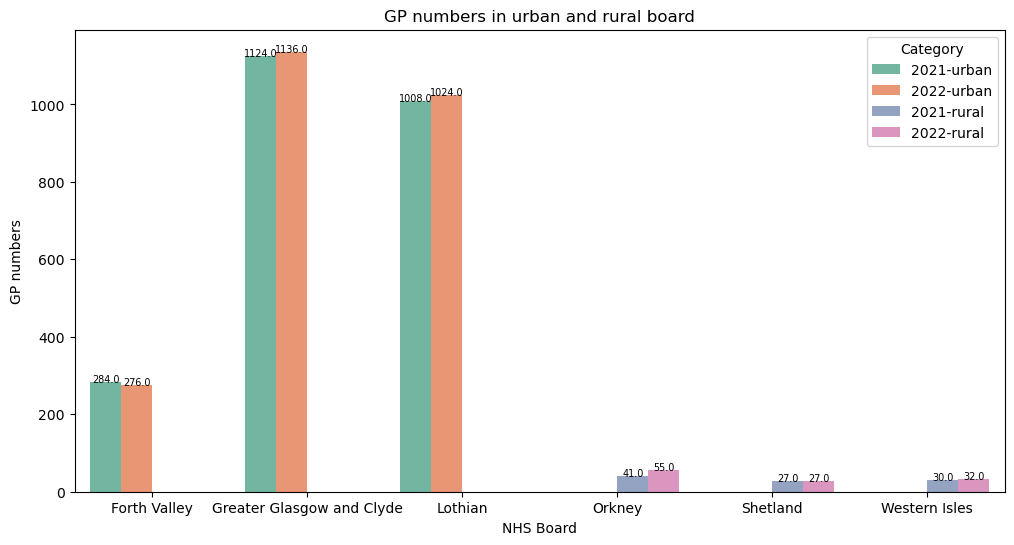

In [9]:
# Import the data file
gp_number = pd.read_excel('https://publichealthscotland.scot/media/16747/table2_number_of_gps_nhsboard_designation_sex_2012_2022.xlsx',sheet_name = 'Table & Chart',header = 8)

# Select the six boards obtained above
rows = [4,6,9,10,11,13]

# Choose years 2021 and 2022
columns = ['Unnamed: 0',2021,2022] 
selected_data = gp_number.loc[rows, columns]

# Construct the new data frame
new_data = pd.DataFrame(selected_data)

# Set up the boards and gp numbers data
x = list(new_data['Unnamed: 0'])
y1 = list(new_data[2021])
y2 = list(new_data[2022])

# Construct the data group, every board has two groups of data: 2021 and 2022
result = list(chain.from_iterable(zip(y1, y2)))

# Combine the data with categories
data = pd.DataFrame({
    'X': np.repeat(x,2),
    'Y': result,
    'Category': np.tile(['2021-urban', '2022-urban','2021-urban', '2022-urban','2021-urban', '2022-urban',
                          '2021-rural',  '2022-rural', '2021-rural',  '2022-rural', '2021-rural',  '2022-rural'], 1),
})

# Initialize the plot size
plt.figure(figsize=(12, 6))

# Plot the data with categories
ax = sns.barplot(x='X', y='Y', hue='Category', data=data, palette='Set2')

# Show every bar's value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 2), textcoords='offset points', fontsize=7)

# Add titles and x-axis and y-axis labels
plt.xlabel('NHS Board')
plt.ylabel('GP numbers')
plt.title('GP numbers in urban and rural board')

# Add  bar chart labels
plt.legend(title='Category')

# Show the plot
plt.show()

```python
# Lines 33-38: seaborn
# URL: https://seaborn.pydata.org/tutorial/categorical.html
# Accessed on 19 Nov 2023.
```

From the above, the differences in GP numbers in urban and rural areas could be obtained. From the time perspective, there are not significant changes from 2021 to 2022. The GP numbers show an **increasing trend** in most boards, decreasing to 276 in Forth Valley, and remaining 27 in Shetland. From the space perspective, the bar chart shows that the GP numbers in **urban** areas are much **larger than** the numbers in **rural** areas. Glasgow has the most GP numbers among these six boards, reaching 1136 in 2022, while Shetland owned the least 27 GP numbers. 

Urban areas always have more GP. Urban areas have more population, which provides the opportunity for medical services development. Therefore, the accessibility of medical resources would become better. The lack of medical resources in rural areas would make residuals more willing to go to urban areas for GP treatment, which may further promote medical development in urban areas, and lead to a further gap in GP numbers between urban and rural areas.

#### A `pie chart` for the difference of three most common diseases for elder people in the specified Urban and Rural areas in 2022


After studying the accessibility of medical resources, we want to study the most common diseases in specified urban and rural areas in 2022. The accessibility of medical resources is directly related to the prevention and treatment of the disease, especially for elder people who often suffer from chronic diseases, so we choose people aged 70 plus to study the three most common diseases, use a pie chart to represent the proportion of elder people suffering from each common diseases, visualize the differences between urban and rural areas.

In [10]:
# Import data
board = pd.read_excel('https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx',sheet_name = 'DP_Board_total')

# Select the data for aged 70 plus people in specified boards in 2022
condition = (board['Year'] == 2022) &(board['Age'].isin(['70-74','75-79','80-84','85plus']))& (board['GPPractice/Area'].isin(['NHS Forth Valley', 'NHS Greater Glasgow and Clyde', 'NHS Lothian', 'NHS Orkney','NHS Shetland','NHS Western Isles']))
selected_rows = board.loc[condition].copy()

# Combine the board with different age groups 
age_group = {'70-74': '70-85plus', '75-79': '70-85plus', '80-84': '70-85plus', '85plus': '70-85plus'}
selected_rows.loc[:, 'Age'] = selected_rows['Age'].map(age_group)

# Sum the values for different age groups
# Obtain the sum of people suffering diseases in different boards
new1 = selected_rows.groupby(['GPPractice/Area', 'Age']).sum(numeric_only=True)
new1 = new1.reset_index()

# Select the data for different diseases
selected_columns = new1.iloc[:, 0:23]

# Set up new data frame
new = pd.DataFrame(selected_columns)
new.head()

,GPPractice/Area,Age,Year,PracticeCode,PatientCount_Asthma,PatientCount_Atrial Fibrillation,PatientCount_Cancer,PatientCount_Chronic Kidney Disease (CKD),PatientCount_Chronic Obstructive Pulmonary Disease (COPD),PatientCount_Coronary Heart Disease (CHD),...,PatientCount_Eating Disorder,PatientCount_Epilepsy,PatientCount_Heart Failure,PatientCount_Hypertension,PatientCount_Mental Health,PatientCount_Osteoporosis,PatientCount_Palliative Care,PatientCount_Peripheral Arterial Disease (PAD),PatientCount_Rheumatoid Arthritis,PatientCount_Stroke and TIA
0,NHS Forth Valley,70-85plus,8088,0.0,2663,3772,4944,6029,3140,6236,...,26,527,1449,18072,351,352,605,1151,594,3552
1,NHS Greater Glasgow and Clyde,70-85plus,8088,0.0,9672,14351,17397,22837,13773,22865,...,108,2170,6903,63598,1642,2455,1910,4508,2288,14226
2,NHS Lothian,70-85plus,8088,0.0,8436,11601,17631,16109,9528,16902,...,165,1522,4217,54526,1316,2147,2196,3788,2177,11852
3,NHS Orkney,70-85plus,8088,0.0,243,372,454,561,230,507,...,5,60,149,1799,35,33,81,102,91,331
4,NHS Shetland,70-85plus,8088,0.0,312,454,558,732,220,543,...,0,56,244,2071,30,20,78,129,91,339


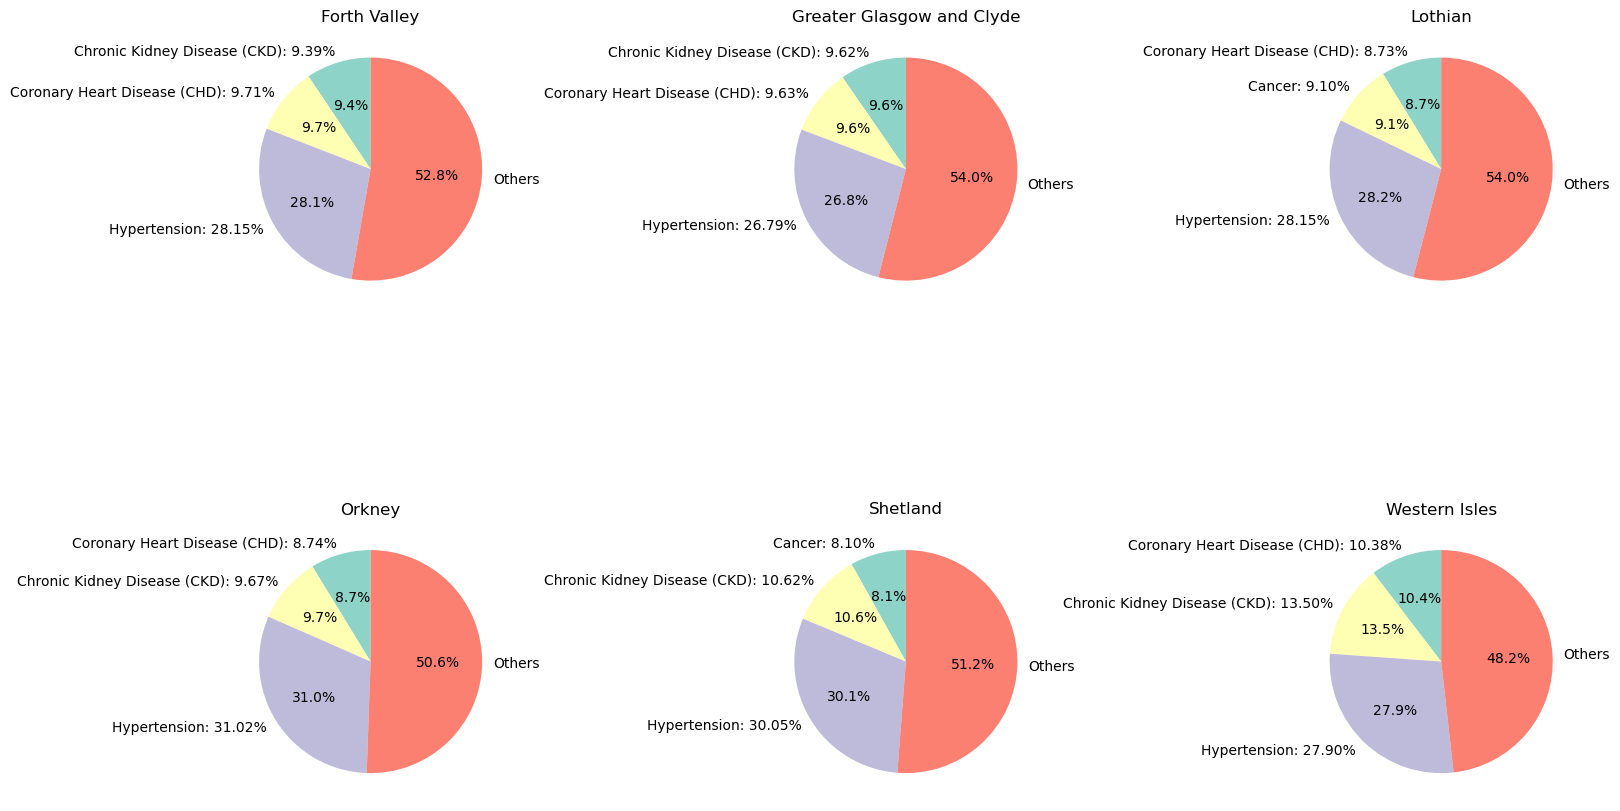

In [11]:
# Construct the matrix about elder people diseases data based on each board
matrix = new.iloc[0:, 4:]

# Calculate the sum of diseased elder people
sums = matrix.sum(axis=1)

# calculate the proportion of each disease
data_list = 100*matrix / sums.values[:, np.newaxis]
data_list=np.array(data_list)

# Set up the indices and proportion list
max_1 = []
max_value = []

# Use loop to find the three most common diseases in each board
for row in data_list:
    # Find the index after sorting
    indices = np.argsort(row)
    
    # Apply the last three indices, means the three largest proportion
    max_indices = indices[-3:]
    
    # Produce the three most common diseases proportion and their indices in original list
    max_proportion = row[max_indices]
    # Update the three most common diseases indices
    max_1.append(max_indices)
    # Update the three most common diseases proportion
    max_value.append(max_proportion)

# Set diseases types
names = ['Asthma','Atrial Fibrillation','Cancer','Chronic Kidney Disease (CKD)','Chronic Obstructive Pulmonary Disease (COPD)','Coronary Heart Disease (CHD)','Dementia','Depression','Diabetes','Eating Disorder','Epilepsy','Heart Failure','Hypertension','Mental Health','Osteoporosis','Palliative Care','Peripheral Arterial Disease (PAD)','Rheumatoid Arthritis','Stroke and TIA']

# Find the three most common diseases for each board
common_type = np.array(names)[np.array(max_1)]

# Combine the diseases proportion with diseases types
disease_data = [
    (max_value[0], np.array(common_type[0])),
    (max_value[1], np.array(common_type[1])),
    (max_value[2], np.array(common_type[2])),
    (max_value[3], np.array(common_type[3])),
    (max_value[4], np.array(common_type[4])),
    (max_value[5], np.array(common_type[5])),
]

# Set up the pie chart plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Use loop to construct each board pie chart
for (proportion, labels), ax in zip(disease_data, axes.flatten()):
    # Calculate the number of rest elder people who suffering from other diseases
    total = 100 - np.sum(proportion)
    
    # Create the new diseases number list, add the rest data
    proportion = np.append(proportion, total)
    
    # Create labels, set the rest number as "others"
    labels = [f"{label}: {value:.2f}%" for label, value in zip(labels, proportion[:-1])] + ["Others"]
    
    # Plot the pie chart for each board
    ax.pie(proportion, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))

# Update each pie chart title
for i, ax in enumerate(axes.flatten()):
    ax.set_title(f"{x[i]}")
    
# Set up arrangements for subplots
plt.tight_layout()

# Show the plots
plt.show()


From above, shows that the **types of three common diseases** are different between urban and rural areas. In urban areas, coronary heart disease(CHD) and hypertension are common diseases for elder people, while chronic kidney disease (CKD) and hypertension are common in rural areas. The different living habits and environments may cause the differences in common disease types. Also, the accessibility of medical resources is an important factor, which may help elder people detect chronic diseases and increase the probability of treatment.

**Hypertension** is the **most common** disease for elder people in six boards. There are higher proportion of elderly people suffering hypertension in rural areas, Orkney and Shetland reached over 30% in 2022. The lack of medical resources may hinder the diagnosis and prevention of chronic diseases in the elderly, leading to a higher prevalence of illness.

#### A `bar chart` for differences of the number of carehome patient in top 3 urban and rural NHS boards over year 2021 and 2022

In this small part, we want to know if there is a difference in the number of patients treated in a care home between urban and rural areas, and also compare the years 2021 and 2022 in detail. The data related to the care home patient's number can be obtained from one sheet of the demographics table. From the previous part, we have got 6 NHS Boards that we want to look at for urban and rural areas respectively, then we sum up care home patients number for each selected board in 2021 and 2022. After plotting the filtered and consolidated data, we got a bar chart for urban and rural boards in these two years reflecting the care home patient number clearly.

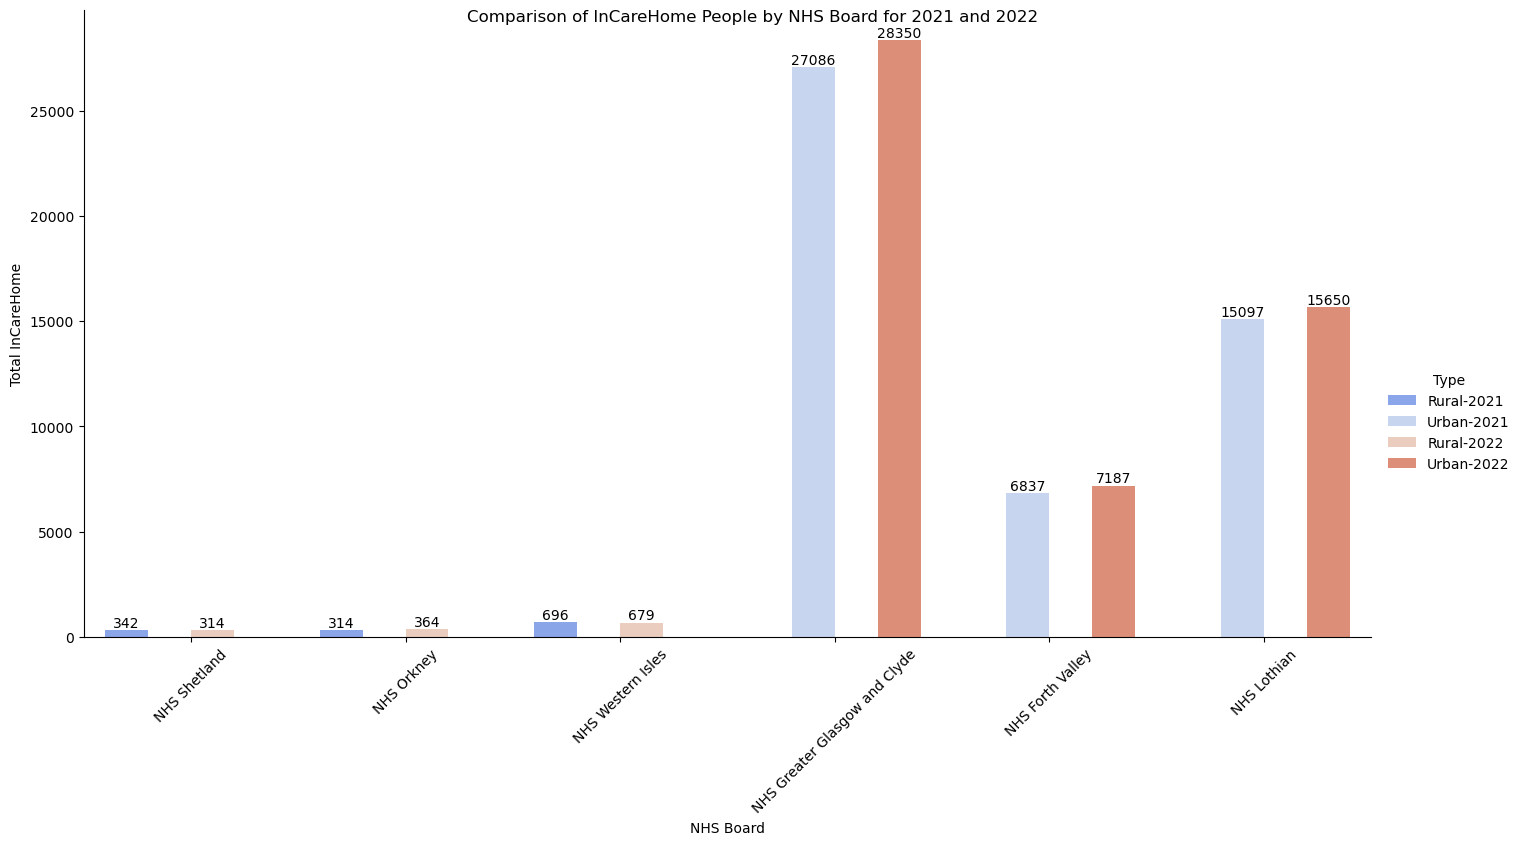

In [12]:
# Read table to get the number of patients in carehome and only see year 2021 and 2022
care_home = pd.read_excel('https://publichealthscotland.scot/media/22255/demographics_2023_q1.xlsx',sheet_name= 'Care Home')
care_home = care_home[care_home['Quarter'].str.contains('2021|2022', regex=True)] 

# Creat some empty big dictionaries for storing data
each_rural_board_2021 = {}
each_rural_board_2022 = {}
each_urban_board_2021 = {}
each_urban_board_2022 = {}

# Use a for-loopmto manipulate data and fill dictionaries for each NHS Board 
for board in top_3_rural+top_3_urban:
    # Filter data for the current Board
    filtered_df = care_home[care_home['Board'] == board]
    
    # 2021
    # Filter out the rows containing '2021' and calculate the sum number of InCareHome patient
    df_2021 = filtered_df[filtered_df['Quarter'].str.contains('2021', regex=True)]
    total_2021 = df_2021['InCareHome'].sum()
    
    # Fill this number as value for its NHS board as key
    if board in top_3_rural:
        each_rural_board_2021[board] = total_2021
    else:
        each_urban_board_2021[board] = total_2021
    
    # 2022
    # Filter out the rows containing '2022' and calculate the sum number of InCareHome patient
    df_2022 = filtered_df[filtered_df['Quarter'].str.contains('2022', regex=True)]
    total_2022 = df_2022['InCareHome'].sum()
    if board in top_3_rural:
        each_rural_board_2022[board] = total_2022
    else:
        each_urban_board_2022[board] = total_2022

# Board list
board = list(each_rural_board_2022.keys()) + list(each_urban_board_2022.keys())

# Total number of care home patients in each year for calculating the proportion
care_home_values_2021 = list(each_rural_board_2021.values()) + list(each_urban_board_2021.values())
care_home_values_2022 = list(each_rural_board_2022.values()) + list(each_urban_board_2022.values())

# Define a type for each Board ('Rural' or 'Urban')
board_types = ['Rural'] * len(each_rural_board_2022) + ['Urban'] * len(each_urban_board_2022)

# Set for our legend
board_types1 = [i+ '-' + '2021' for i in board_types]
board_types2 = [i+ '-' + '2022' for i in board_types]

# Convert to a dataframe format
data_for_carehome_2021 = pd.DataFrame({'Board': board, 'Total InCareHome': care_home_values_2021,'Type': board_types1})
data_for_carehome_2022 = pd.DataFrame({'Board': board, 'Total InCareHome': care_home_values_2022,'Type': board_types2})

# Combine these two dataframes togther
combined_data = pd.concat([data_for_carehome_2021, data_for_carehome_2022])

# Create a bar chart of groups using seaborn
g = sns.catplot(x='Board', y='Total InCareHome', hue='Type', data=combined_data, kind='bar', height=7, aspect=2, palette='coolwarm')

# Add titles and labels
g.fig.suptitle('Comparison of InCareHome People by NHS Board for 2021 and 2022')
g.set_axis_labels('NHS Board', 'Total InCareHome')
g.set_xticklabels(rotation=45)

# Adds a value to the bar using two for loops
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

By analyzing the graph above in an overview way, we can find that urban Scotland patients are more willing to live in a care home for treatments. This is consistent with the usual ideas in our daily life, and the care home patient number of bar charts from urban boards is much higher than that from rural boards. If compared in a time view, we can easily find the number increased from the left bar to the right bar in each board. This shows that people in Scotland are **more likely to be treated in a care home** in the future, each board can take measures to improve the quality and condition of care homes to face and solve this problem, especially rural NHS Boards. 

#### A `bar chart` for differences of the deprivation proportion of patients in top 3 urban and rural boards over year 2021 and 2022

Another aspect we can discuss is the relation between the urban degree and the deprivation proportion. In common sense, people may think that rural areas are more likely to have a relatively higher deprivation proportion. So in terms of this issue, how about the actual circumstances in Scotland? Is this a generally stable tendency from 2021 to 2022? 

To figure out these questions, we should visualize the deprivation proportion in those selected NHS Boards over the years. Similarly, the demographics table is also useful to this case, we can get the number of patients in different degrees of deprivation with all quarters and only interest in 2021 and 2022 again. The degree of deprivation is defined by SIMD deciles. Note that we define SIMD 1-5 into group deprivation which includes the relative most deprived people, and SIMD 6-10 into group not deprivation. Furthermore, we calculated the proportion of each group by dividing the total patient number for each selected NHS Board in 2021 and 2022. In the end, we got a similar graph like a care home case to compare over years and groups.

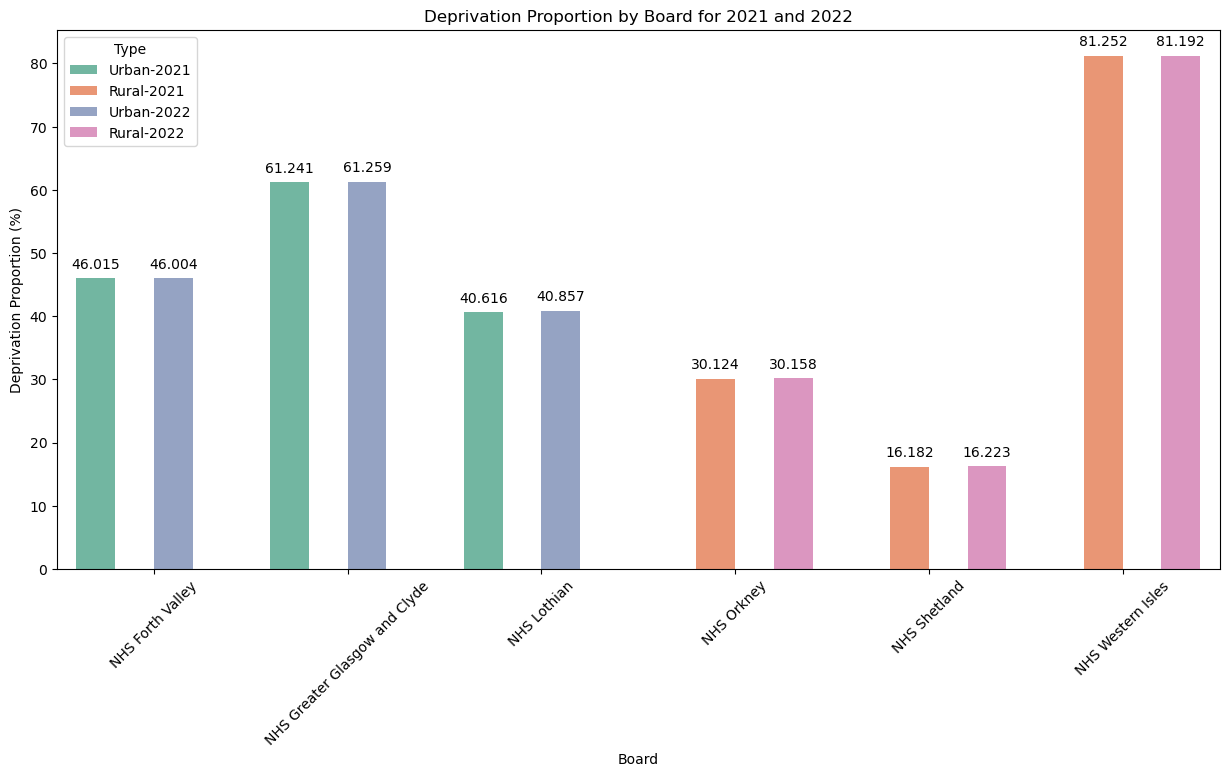

In [13]:
# Read table to get the number of patients for each SIMD value which is in Decile column and only see year 2021 and 2022
simd = pd.read_excel('https://publichealthscotland.scot/media/22255/demographics_2023_q1.xlsx',sheet_name= 'SIMD')
simd = simd.loc[simd['Quarter'].str.contains('2021|2022', regex=True)]

# Define a function to classify SIMD
def classify_simd(simd_string):
    '''
    This funtion wants to classify patients into 2 groups based on the SIMD value, SIMD 1 means the most deprivation.

    Input:
        simd_string: a string that is used to classify
    
    Output:
        A string that is the group for these deprivation degree. It can be 'deprivation', 'not deprivation' and 'unknown' for 
        pointless data. We only have SIMD from 1 to 10.

    '''

    # Gets the last character of the string and converts it to an integer
    simd_value = int(simd_string.split()[-1])

    # Use if-elif-else statement to distinguish group
    if 1 <= simd_value <= 5:
        return 'deprivation'
    elif 6 <= simd_value <= 10:
        return 'not deprivation'
    else:
        return 'unknown'  # Specify other dirty data

# Apply this defined function to create a new column for deprication group
simd['SIMD Category'] = simd['Decile'].apply(classify_simd)

# Only analysis top 3 Boards for urban and rural groups
filtered_simd = simd[simd['Board'].isin(top_3_rural+top_3_urban)]

# Create a separate copy
filtered_simd = filtered_simd.copy()

# Select the year for data
filtered_simd['Year'] = filtered_simd['Quarter'].str.extract(r'(\d{4})')

# Select the data for 2021 and 2022
simd_2021 = filtered_simd[filtered_simd['Year'] == '2021']
simd_2022 = filtered_simd[filtered_simd['Year'] == '2022']

# Calculate the total patient number of each selected NHS board
total_simd_2021 = simd_2021.groupby('Board')['Patients'].sum().reset_index()
total_simd_2022 = simd_2022.groupby('Board')['Patients'].sum().reset_index()

# Calculate the total number of Patients by grouping NHS Board and its SIMD Category: deprivation/not deprivation
# 2021
grouped_simd_2021 = simd_2021.groupby(['Board', 'SIMD Category'])['Patients'].sum().reset_index()
deprivation_data_2021 = grouped_simd_2021[grouped_simd_2021['SIMD Category'] == 'deprivation'].reset_index(drop=True)

# 2022
grouped_simd_2022 = simd_2022.groupby(['Board', 'SIMD Category'])['Patients'].sum().reset_index()
deprivation_data_2022 = grouped_simd_2022[grouped_simd_2022['SIMD Category'] == 'deprivation'].reset_index(drop=True)

# Combine our data together by NHS Board
merged_data_2021 = total_simd_2021.merge(deprivation_data_2021, on='Board', suffixes=('_total', '_deprivation'))
merged_data_2022 = total_simd_2022.merge(deprivation_data_2022, on='Board', suffixes=('_total', '_deprivation'))
new_board_types = ['Urban']*3 + ['Rural']*3

# Calculate the proportion for SIMD Category in urban and rural groups over year 2021 and 2022
merged_data_2021['Deprivation Proportion'] = (merged_data_2021['Patients_deprivation'] / merged_data_2021['Patients_total'])*100
merged_data_2021['Type'] = [i + '-' + '2021' for i in new_board_types]
merged_data_2022['Deprivation Proportion'] = (merged_data_2022['Patients_deprivation'] / merged_data_2022['Patients_total'])*100
merged_data_2022['Type'] = [i + '-' + '2022' for i in new_board_types]

# Combine data for plotting
combined_simd_proportion= pd.concat([merged_data_2021, merged_data_2022])

# Set up figure
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='Board', y='Deprivation Proportion', hue='Type', data=combined_simd_proportion, palette='Set2')

# Set the title and label
plt.title('Deprivation Proportion by Board for 2021 and 2022')
plt.xlabel('Board')
plt.ylabel('Deprivation Proportion (%)')
plt.xticks(rotation=45)

# Adds a value to the bar using for-loop
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Show our figure
plt.show()


From the obtained bar charts, the interesting thing is that **not all rural areas have a big deprivation proportion**, which really goes against our conventional ideas. Moreover, the proportion of exploitation in 3 urban areas is at a relatively high level, for example, Glasgow and Clyde have over a half people in a position of deprivation. The area with the highest deprivation proportion is the Western Isles, it is one of the most inaccessible areas in the UK and sparsely populated. These areas are also separated from the islands of Great Britain and the Inner Hebrides by the stormy Minch Channel and the Little Minch Channel. 

The economic situation of the islands remains relatively precarious due to lots of reasons. Their incomes largely depend on fish farming but it is vulnerable to environmental impacts as well as changing market pressures. Maybe that is the reason why Western Isles has a high deprivation level. However, other rural areas Orkney and Shetland have the two lowest deprivation proportions. The Orkney coastal service industry and helicopter service flourished and the main economic sources of Shetland are fishing and oil under the North Sea. We guess these could be some factors that led to this result. And we also conclude that **people living in cities do not mean they are very rich**, and **living in the countryside does not mean they are all poor**. 

From 2021 to 2022, there is almost no changes happened in the deprivation proportion. Finally, it shows the proportion is **stable** and perhaps the rich and poor are relatively entrenched in Scotland.

All in all, we studied the geographical differences in registered numbers between urban and rural using a map. The following bar charts can reflect the differences regarding accessibility, care home patient number, and deprivation proportion. The pie chart shows some diseases with the highest number among old people in urban and rural areas in Scotland.

---
## **Investigate the prevalence of *heart failure* and *depression* for different age groups over years**


After analyzed the differences in urban and rural areas, additionally, we will focus on some specific diseases, namely *heart failure* and *depression*. In recent years, there has been an increase in the number of people suffering from depression, especially during epidemics. As for heart failure, the relationship between it and depression goes both ways. Heart failure may increase the risk of developing depression, while depression may worsen the symptoms of heart failure.

#### A `line graph` for prevalence of heart failure and depression in different age groups from 2018 to 2023

To more effectively illustrate the relationship between the prevalence of diseases and age groups, line graphs were used. These graphs offer a clear, visual representation of how disease prevalence varies across different ages over time. From the comprehensive analysis of various diseases from 2018 to 2023, two notable trends emerged for depression and heart failure.  

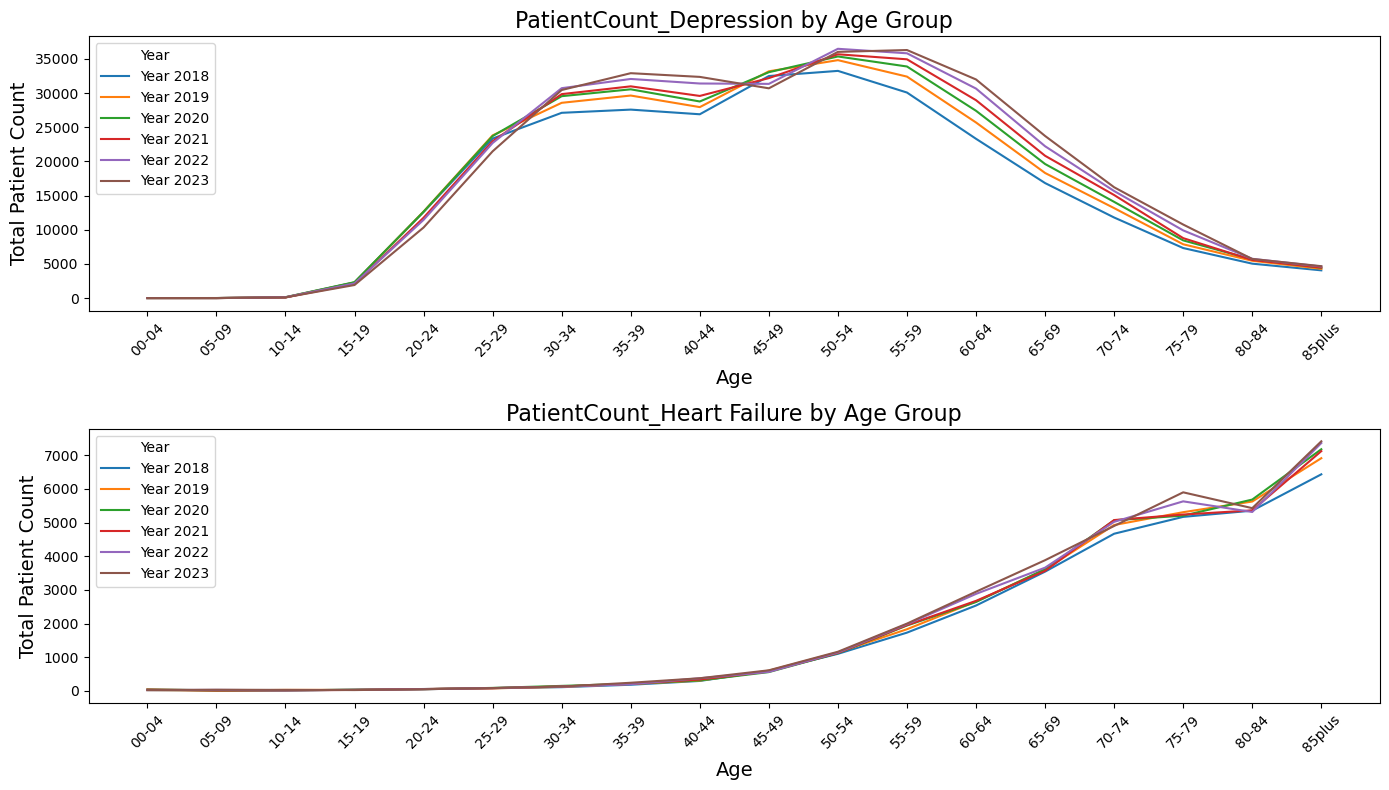

In [14]:
# Select the data to exclude rows where the Age is 'All' and replace NaN values with 0
board = pd.read_excel('https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx', sheet_name="DP_Board_total")
board = board[board['Age'] != 'All'].fillna(0)

# Get the unique years from the 'Year' column
unique_years = board['Year'].unique()

# Create a list of columns that start with 'PatientCount'
# patient_count= [col for col in board_all.columns if col.startswith('PatientCount')]
patient_count= ['PatientCount_Depression','PatientCount_Heart Failure']

# Group the data by 'Year' and 'Age' and sum the values for the patient count columns
trend_data = board.groupby(['Year', 'Age'])[patient_count].sum().reset_index()

fig, axes = plt.subplots(len(patient_count), 1, figsize=(14, 8))
# Loop through each disease to plot the total patient count by age group
for i, disease in enumerate(patient_count):
    # fig, axes = plt.subplots(figsize=(14, 8)) # Create a subplot with custom size
    
    for year in unique_years: # Plot the total patient count for each age group by year
        year_data = trend_data[trend_data['Year'] == year]
        axes[i].plot(year_data['Age'], year_data[disease], label=f'Year {year}')
       
    axes[i].set_title(f'{disease} by Age Group', fontsize=16)
    axes[i].set_xlabel('Age', fontsize=14)
    axes[i].set_ylabel('Total Patient Count', fontsize=14)
    axes[i].legend(title='Year', loc='upper left')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

For depression, the line graphs highlighted a distinct pattern. There was a **significant increase** in the prevalence of depression in **middle-aged groups**, particularly between ages 30 to 64, with the highest peak in the 55-59 age group. This trend suggests that factors such as work-related stress, life transitions might contribute to higher rates of depression in this demographic. The lower prevalence in younger age groups (0-24 years) could indicate either a lower incidence of depression. 

In contrast, the trend for heart failure was totally different. The line graph for heart failure showed a clear **age-dependent increase** in prevalence. The number of patients was lowest in the youngest group (0-24 years) and increased steadly with age. This upward trend was most pronounced in the **elderly population**, particularly those aged 65 and above. The data suggested a strong correlation between advancing age and the risk of heart failure, possibly due to age-related deterioration in heart function. Besides, the year-on-year data for heart failure showed a relatively stable pattern, indicating a consistent prevalence rate across the observed period. 

#### A `boxplot` for prevalence of depression in young middle-aged and old middle-aged from 2018 to 2023

Given the siginificant trend towards heart failure across different age groups, our analysis turned to concentrate on those age groups most affected by depression. We specifically categorized the age groups with the highest prevalence of depression into two segments: young middle-aged (30-49 years) and old middle-aged (50-69 years). This distinction allows for a more deeper understanding of how depression impacts individuals at different stages of midlife.

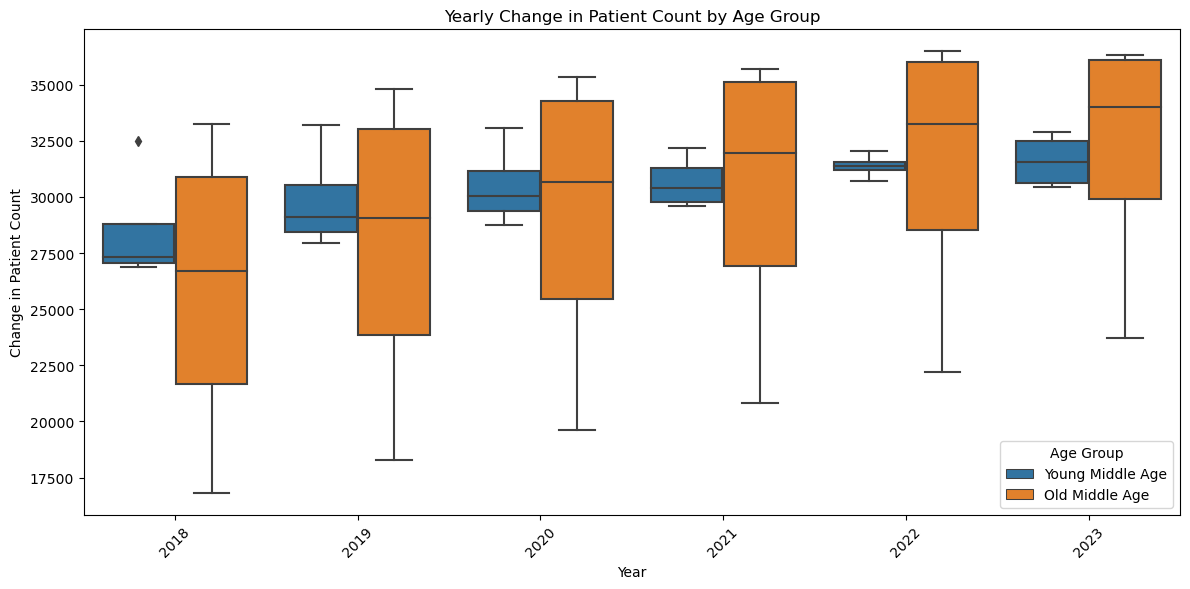

In [15]:
# Define the column name for the patient count related to depression
patient_count_depression = ['PatientCount_Depression']

# Define age ranges for young and old middle age groups
young_middle_age = ['30-34','35-39','40-44','45-49']
old_middle_age = ['50-54','55-59','60-64','65-69']
age_groups = ['Young Middle Age', 'Old Middle Age']

# Select data by year and age, then sum the patient counts for depression
trend_data_depression = board.groupby(['Year', 'Age'])[patient_count_depression].sum().reset_index()

# Initialize a new column 'AgeGroup' with default value 'Other'
trend_data_depression['AgeGroup'] = 'Other'

# Update the 'AgeGroup' column to 'Young Middle Age' for the defined young middle age range
trend_data_depression.loc[trend_data_depression['Age'].isin(young_middle_age), 'AgeGroup'] = 'Young Middle Age'

# Update the 'AgeGroup' column to 'Old Middle Age' for the defined old middle age range
trend_data_depression.loc[trend_data_depression['Age'].isin(old_middle_age), 'AgeGroup'] = 'Old Middle Age'

# Select the data to include only the specified age groups
age_group_data = trend_data_depression[trend_data_depression['AgeGroup'].isin(age_groups)]

# Transform the data to a long format for easier plotting with seaborn
melted_data = age_group_data.melt(id_vars=['Year', 'AgeGroup'],
                                  value_vars=patient_count_depression,
                                  var_name='Disease',
                                  value_name='PatientCount')

# Create a figure with a subplot for each disease
plt.figure(figsize=(12, 6))

# Create a boxplot to visualize the yearly change in patient count by age group
sns.boxplot(x='Year', y='PatientCount', hue='AgeGroup', data=melted_data)
plt.title('Yearly Change in Patient Count by Age Group')
plt.xlabel('Year')
plt.ylabel('Change in Patient Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group', loc='lower right')

plt.tight_layout()
plt.show()

The box plots above provide a visual representation of these annual changes. They are particularly telling in that the median line — the central marker within each box that represents the midpoint of the data — is consistently higher for the old middle-aged group than for the young middle-aged. This suggests that **not only is the old middle-aged group** experiencing a greater number of depression episodes annually, but they are also subject to more significant **year-over-year variations** in patient counts. **The median for both age groups has been increasing over the years** which also shows on the above plot. 

Furthermore, a trend of increasing median patient numbers over the years is evident for both age groups, a fact that correlates with the observations made in the line graphs above. Such a trend shows the growing impact of depression within these populations. The "old middle-aged" category, in particular, showed a more apparent upward trend, hinting at an underlying age-related factor, namely that **the incidence of depression may intensify as a person approaches late middle age**.

#### A stacked `bar` chart of the patient count distribution of different age groups for two diseases across various boards

Following a general analysis by age groups, a more detailed investigation will be conducted by narrowing down the geographic scope. To identify the appropriate area for this focused study, stacked bar charts have been created to depict the patient count distribution of different age groups for two diseases across various boards in the year 2022.

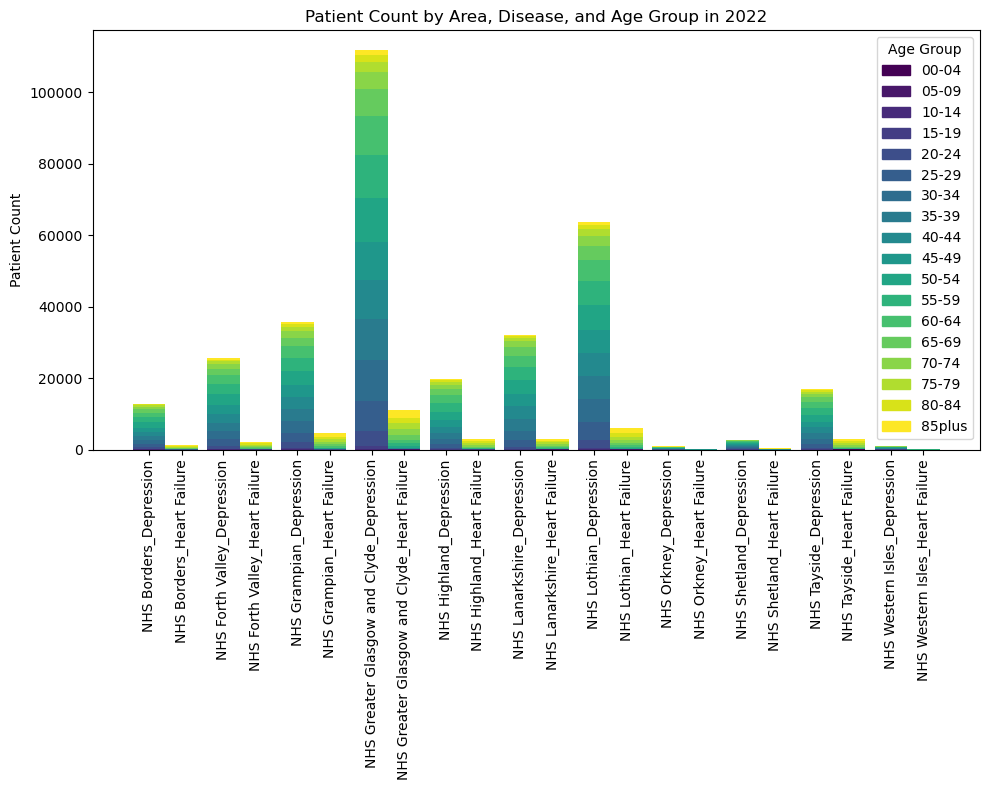

In [16]:
# Get the unique areas from the 'GPPractice/Area' column
unique_areas = board['GPPractice/Area'].unique()

# Generate a list of column names related to patient counts for different diseases
patient_count= ['PatientCount_Depression','PatientCount_Heart Failure']

# Aggregate the data by geographic area, year, and age, and then sum up the patient counts
trend_data = board.groupby(['GPPractice/Area','Year', 'Age'])[patient_count].sum().reset_index()     

# Get the unique years from the 'Year' column
unique_years = board['Year'].unique()

# Filter the dataset to include only the data for the year 2022
data_2022 = trend_data[trend_data['Year'] == 2022]

# Sort and retrieve the list of unique age groups present in the 2022 data
age_groups = sorted(data_2022['Age'].unique())

# Define colors for the age groups using a colormap
age_colors = plt.cm.viridis(np.linspace(0, 1, len(age_groups)))

# Set up the plot with a defined figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Define the width for each bar and the space between groups of bars
bar_width = 0.35
space_between = 0.1

# Initialize lists to hold the x-axis tick positions and labels
xticks = []
xticklabels = []

# Iterate over each area and disease to create stacked bars for each age group
for area_idx, area in enumerate(unique_areas):
    for disease_idx, disease in enumerate(patient_count):
        # Start the stacking process at zero for each bar segment
        bottom = 0
        for age_idx, age in enumerate(age_groups):
            # Calculate the patient count for each age group within the specific area and disease
            count = data_2022.loc[
                (data_2022['GPPractice/Area'] == area) & (data_2022['Age'] == age), disease
            ].sum()
            # Plot the bar at the appropriate position with the calculated height and color
            position = area_idx * (2 * bar_width + space_between) + disease_idx * bar_width
            ax.bar(position, count, bar_width, bottom=bottom, color=age_colors[age_idx])
            # Update the bottom position for the next bar segment in the stack
            bottom += count
        # Set the X-axis scale position for each bar chart
        xticks.append(position)
        # Add labels to each bar chart
        label = f"{area}_{disease.split('_')[1]}"
        xticklabels.append(label)

# Set the scale and label for the x axis
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)

# Set the Y-axis label and title
ax.set_ylabel('Patient Count')
ax.set_title('Patient Count by Area, Disease, and Age Group in 2022')

# Create a legend for the age groups using colored rectangles to match the bar segments
ax.legend([plt.Rectangle((0, 0), 1, 1, color=age_colors[i]) for i in range(len(age_groups))], age_groups, title="Age Group")

# Adjust layout to fit all elements neatly
plt.tight_layout()
plt.show()

Data from 2022 represents the most current full year of information, allowing for an up-to-date analysis of health patterns and the burden of disease. This is particularly relevant in the context of ongoing healthcare challenges and potential recent shifts in public health trends. Earlier years may not reflect the current healthcare environment, including recent interventions, policy changes, or the impact of significant events such as the COVID-19 pandemic. Furthermore, 2023 data may not yet be fully compiled or available for analysis, which could result in an incomplete or skewed understanding of the current health landscape. Based on the provided chart, it is evident that the **NHS Greater Glasgow and Clyde region** has the **largest number** of cases for both Depression and Heart Failure compared to other regions.

#### A `pie chart` of the patient count distribution of different age groups for the two diseases in NHS Greater Glasgow and Clyde 2022

The choice to focus on studying the NHS Greater Glasgow and Clyde region is grounded in the availability and recency of comprehensive data. The above observation justifies a focused study on this particular area for several reasons. Firstly, the significant patient volume highlights the region as a critical area for understanding the burden of these diseases, which is essential for targeted public health interventions and resource allocation. Secondly, due to its larger patient base, findings from this region may offer a more representative insight into the broader health patterns that could apply to similar urban areas. Thirdly, concentrating research efforts on NHS Greater Glasgow and Clyde can lead to a more efficient use of research resources, potentially providing a more substantial impact on the health outcomes of a larger segment of the population. Therefore, studying the NHS Greater Glasgow and Clyde region presents an opportunity to make a pronounced contribution to the understanding and management of Depression and Heart Failure within the context of public health.

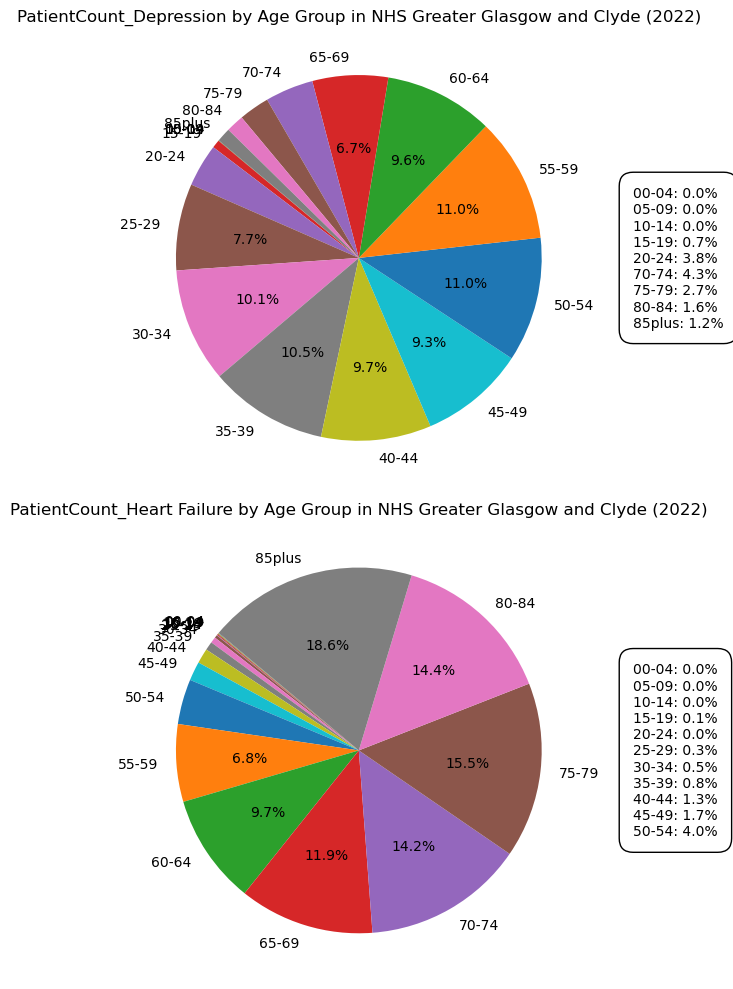

In [17]:
# Load data
board = pd.read_excel('https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx', sheet_name="DP_Board_total")

# Set the canvas and subgraph layout
fig, axes = plt.subplots(2, 1, figsize=(8, 10)) 

# Filter the data for the selected area and the year 2022
selected_area = 'NHS Greater Glasgow and Clyde'
board_area_2022 = board[(board['GPPractice/Area'] == selected_area) & (board['Year'] == 2022)]

# List of diseases to be analyzed
diseases = ['PatientCount_Depression', 'PatientCount_Heart Failure']

# Exclude the 'All' age group from the analysis
board_area_2022 = board_area_2022[board_area_2022['Age'] != 'All']

# Loop through each disease to create pie charts
for i, disease in enumerate(diseases):
    # Group data by age and calculate the sum of patient counts for each age group
    disease_by_age = board_area_2022.groupby('Age')[disease].sum()
    # Calculate the percentage of each age group in the total patient count
    percentages = 100 * disease_by_age / sum(disease_by_age)
    # Initialize a list to keep track of small percentage groups
    small_groups = []

    # Create a pie chart for the current disease
    wedges, _, autotexts = axes[i].pie(disease_by_age, labels=disease_by_age.index, 
                                       autopct=lambda pct: f'{pct:.1f}%' if pct >= 5 else '', 
                                       startangle=140)

    # Process each pie slice for the presence of small percentage groups
    for autotext, pct, age_group in zip(autotexts, percentages, disease_by_age.index):
        if pct < 5:
            # Append small percentage groups to the list
            small_groups.append(f'{age_group}: {pct:.1f}%')
            # Remove text from the pie chart for small percentage groups
            autotext.set_text('')

    # Add a text box next to the pie chart for small percentage groups
    text_str = '\n'.join(small_groups)
    axes[i].text(1.1, 0.5, text_str, transform=axes[i].transAxes, ha='left', va='center', 
                 fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

    # Set a title for each pie chart based on the disease
    axes[i].set_title(f'{disease} by Age Group in {selected_area} (2022)')

# Adjust the overall layout and display the plot
plt.tight_layout()
plt.show()

Based on the provided pie charts depicting the distribution of patient counts for Depression and Heart Failure in the NHS Greater Glasgow and Clyde area for the year 2022:

**For Depression:**
- The age groups 60-64, 65-69, and 55-59 have high patient counts, indicating a significant burden of depression within these older adult age ranges.
- Younger age groups, particularly 20-24 and 50-54, also show notable representation, which may reflect specific stressors or health factors relevant to these demographics.
- The smallest proportions are seen in the very young (0-14) and oldest (85plus) age groups, as well as those aged 15-19 and 80-84. The low patient counts in these age groups could be due to lower prevalence, better mental health, or underdiagnosis.

**For Heart Failure:**
- The patient count is most prominent in the oldest age groups, particularly 80-84 and 85plus, which is consistent with heart failure being more common as age increases.
- The age groups 70-74 and 75-79 also have a significant share of the patient count, reinforcing the trend that heart failure is a disease associated with aging.
- The younger age groups from 0-64 have very low patient counts, which suggests a relatively lower prevalence of heart failure among these ages.

From these observations, we can conclude that for subsequent analysis of disease rate trends over time, focusing on the age groups with a higher burden of disease would be most informative. Specifically, for Depression, we might prioritize the 55-69 age range, and for Heart Failure, the focus might be more on the 70-plus age range.

#### Two sets of comparative `line charts` of rate variations in two diseases across various age groups, contrasting data from NHS Greater Glasgow and Clyde against Scotland overall

After conducting a basic analysis of patient count, we aim to understand which groups have higher rates of disease and how these rates change over time. This is because the number of patients alone does not directly indicate which age group is more susceptible, as it could simply be that the population base of that age group is larger. In terms of age groups that are too small to warrant further trend analysis, we can consider omitting those with a proportion of less than 5% of the total patient count. For Depression, this could mean excluding age groups under 20 and over 80, and for Heart Failure, it might mean excluding all age groups under 70. By focusing on the age groups with more substantial patient counts, we can ensure that our analysis is both statistically meaningful and relevant to the largest affected populations.

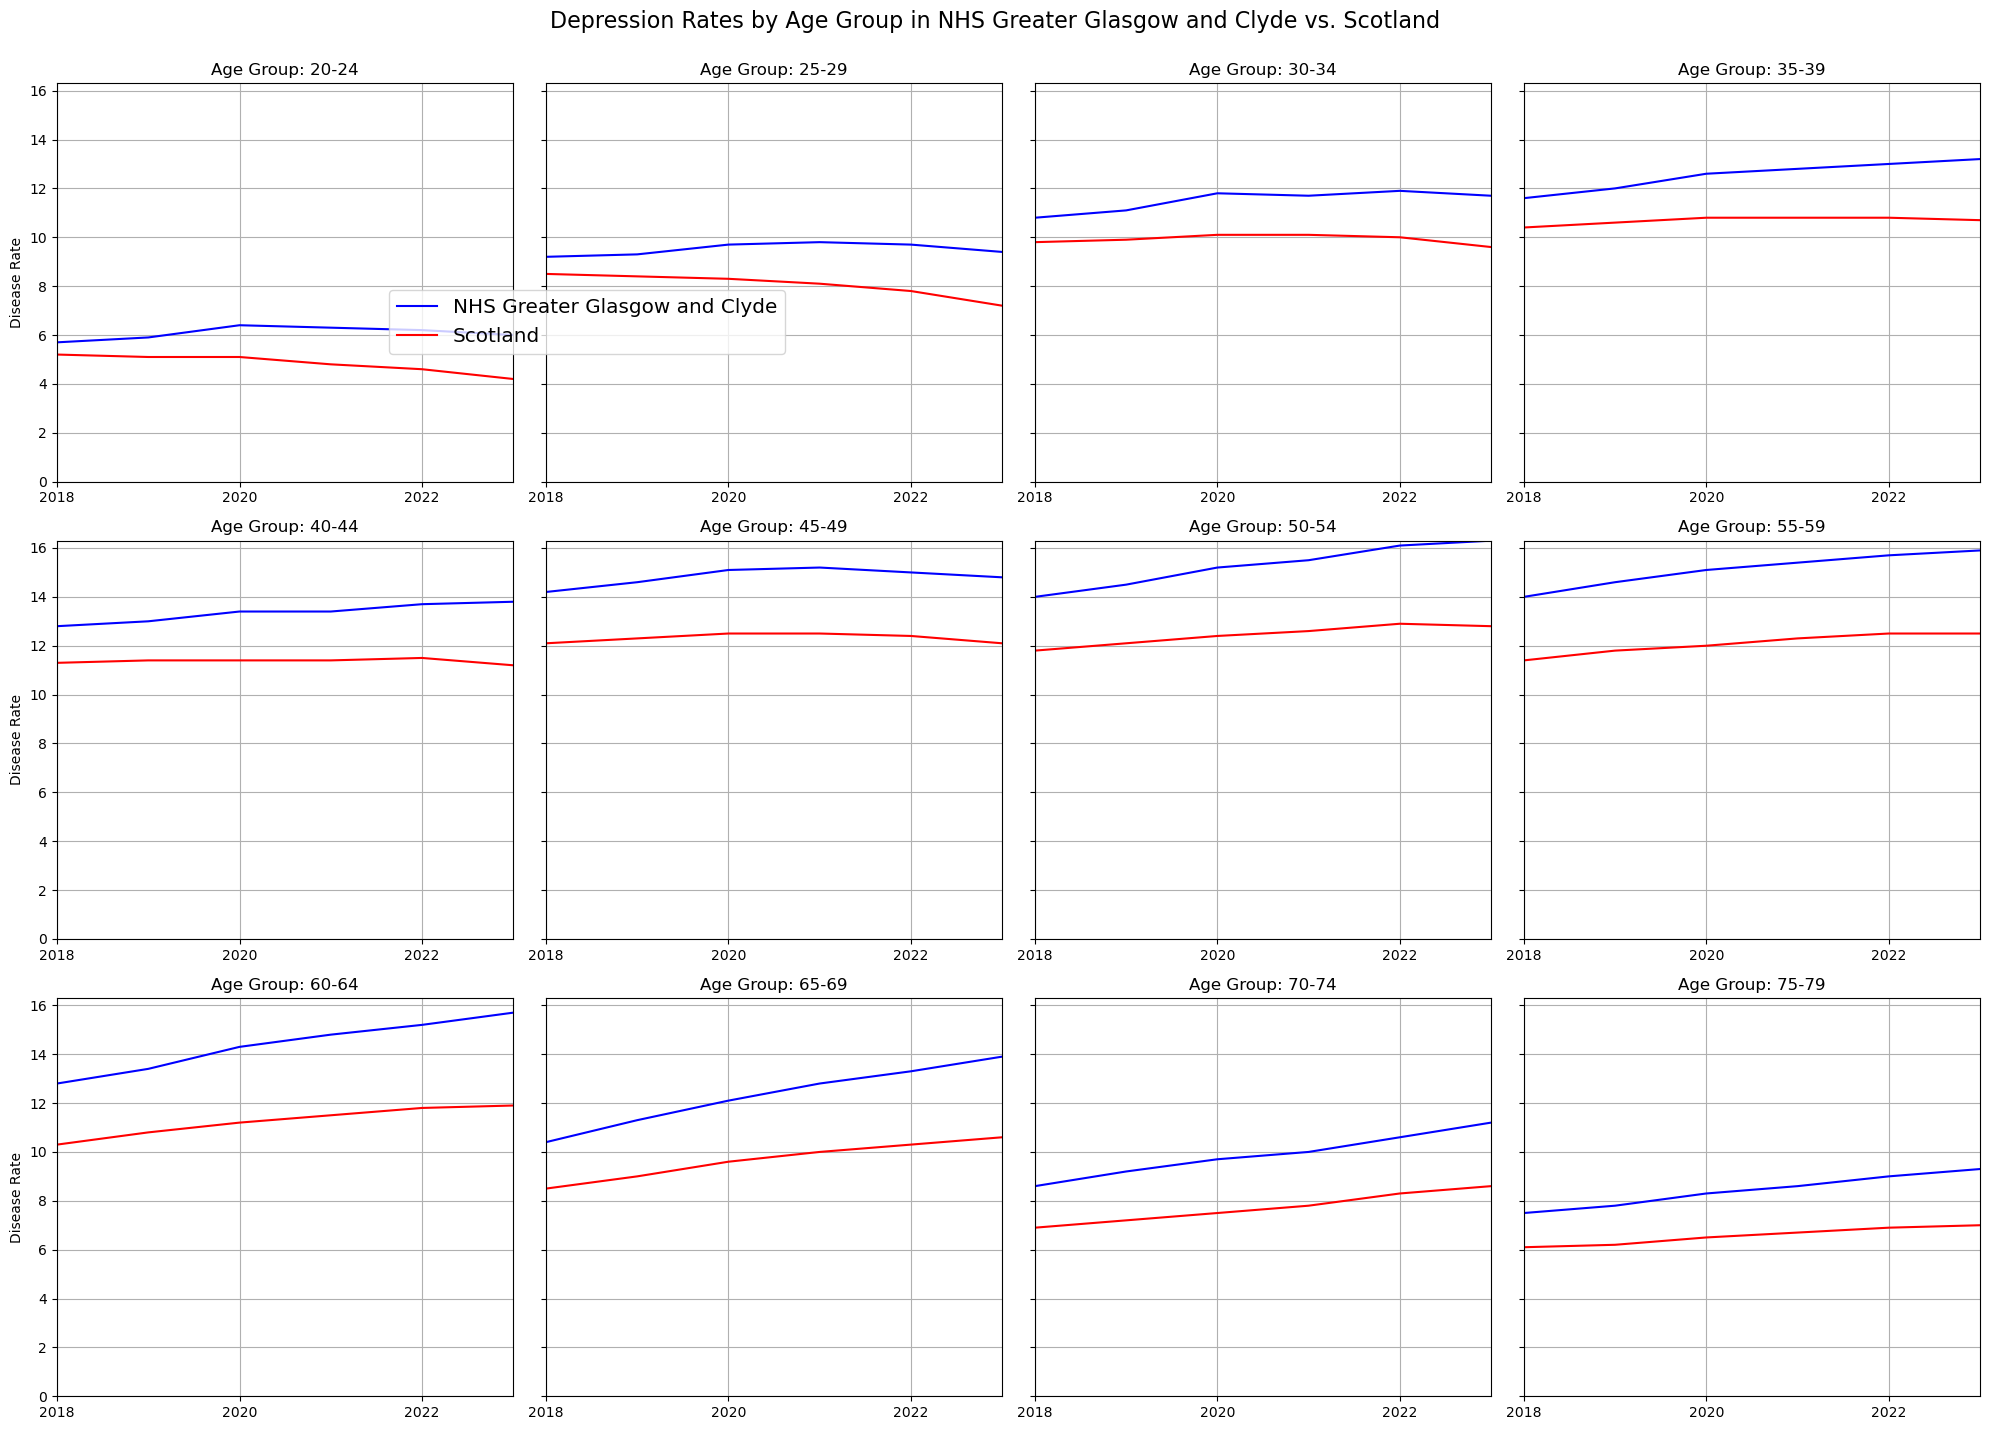

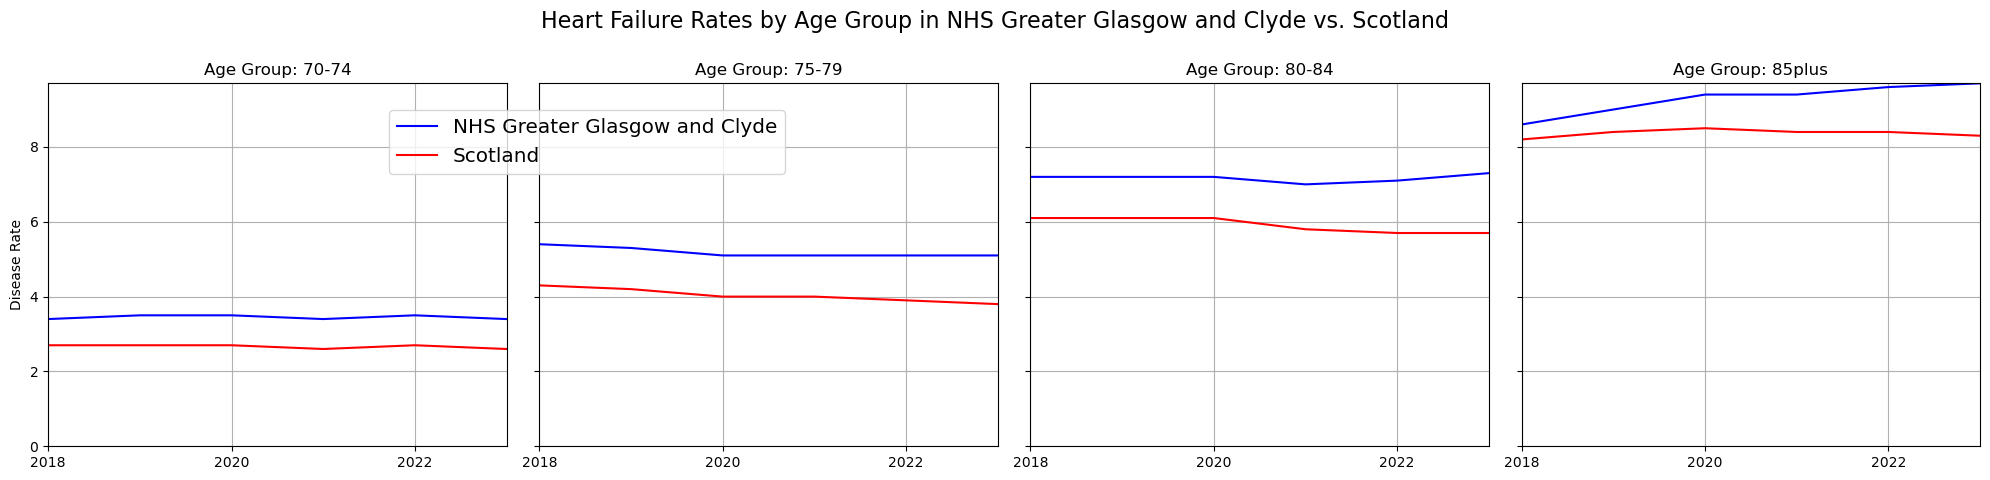

In [18]:
# Read in the local dataset for board-specific and Scotland-wide disease prevalence
board = pd.read_excel('https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx', sheet_name="DP_Board_total")
scotland_total = pd.read_excel('diseaseprevalence_scotland_total.xlsx', sheet_name="DP_Scotland_total")

# Define the area NHS Greater Glasgow and Clyde for the analysis
selected_area = 'NHS Greater Glasgow and Clyde'
# List of diseases to analyze
diseases = ['Rate_Depression', 'Rate_Heart Failure']

# Define the age groups to exclude from the analysis for each disease
excluded_age_groups_depression = ['00-04', '05-09', '10-14', '15-19', '80-84', '85plus']
excluded_age_groups_heart_failure = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69']

# Define the layout structure for subplots of each disease
layouts = [(3, 4), (1, 4)]  # Rows and columns for Depression and Heart Failure, respectively

# Loop through each disease to plot the disease rates by age group
for disease, layout, excluded_age_groups in zip(diseases, layouts, [excluded_age_groups_depression, excluded_age_groups_heart_failure]):
    # Filter data for NHS Greater Glasgow and Clyde and Scotland, ensuring the age is specified and disease rate is greater than 0
    area_data = board[(board['GPPractice/Area'] == selected_area) & (board['Age'] != 'All') & (board[disease] > 0)]
    scotland_data = scotland_total[(scotland_total['GPPractice/Area'] == 'Scotland') & (scotland_total['Age'] != 'All') & (scotland_total[disease] > 0)]
    
    # Remove the specified excluded age groups from the dataset
    area_data = area_data[~area_data['Age'].isin(excluded_age_groups)]
    scotland_data = scotland_data[~scotland_data['Age'].isin(excluded_age_groups)]

    # Get a sorted list of unique age groups in the dataset
    age_groups = sorted(area_data['Age'].unique())

    # Set up the subplots based on the defined layouts
    fig, axes = plt.subplots(nrows=layout[0], ncols=layout[1], figsize=(layout[1] * 5, layout[0] * 5))
    # Flatten the axes array for easy one-dimensional iteration
    axes = axes.flatten()

    # Gather all unique years in the dataset and find the maximum disease rate
    years = sorted(area_data['Year'].unique())
    max_disease_rate = max(area_data[disease].max(), scotland_data[disease].max())

    # Iterate through each age group and plot their disease rates
    for i, age_group in enumerate(age_groups):
        ax = axes[i]
        # Plot the disease rate for NHS Greater Glasgow and Clyde
        age_group_data_area = area_data[area_data['Age'] == age_group]
        ax.plot(age_group_data_area['Year'], age_group_data_area[disease], color='blue')
        # Plot the disease rate for Scotland
        age_group_data_scotland = scotland_data[scotland_data['Age'] == age_group]
        ax.plot(age_group_data_scotland['Year'], age_group_data_scotland[disease], color='red')
        
        # Set up the title, limits, and ticks for each subplot
        ax.set_title(f'Age Group: {age_group}')
        ax.set_xlim([min(years), max(years)])
        ax.set_ylim([0, max_disease_rate])
        ax.set_xticks(years[::2])  # Set x-ticks to every other year for clarity
        ax.grid(True)

        # Set the y-axis label only for the first subplot in each row
        if i % layout[1] == 0:
            ax.set_ylabel('Disease Rate')
        else:
            ax.set_yticklabels([])
    
    # Add a main title for each figure
    main_title = 'Depression Rates by Age Group' if disease == 'Rate_Depression' else 'Heart Failure Rates by Age Group'
    fig.suptitle(f'{main_title} in NHS Greater Glasgow and Clyde vs. Scotland', fontsize=16, y=0.98)

    # Create a global legend for all subplots
    fig.legend(['NHS Greater Glasgow and Clyde', 'Scotland'], loc='upper right', fontsize='x-large', bbox_to_anchor=(0.4, 0.8))

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust the layout
    plt.show()  # Display the plots

Based on the provided description of the chart the blue line represents the depression rate in NHS Greater Glasgow and Clyde and the red line represents Scotland as a whole:

1.  **Stable Rates Before Age 50:** 
The relatively flat lines for age groups below 50 suggest that the depression rates have remained stable over time. This could be due to early detection and intervention strategies that are effectively managing depression within these younger age groups. It may also reflect a period of life with stable employment, family life, or social support which can act as protective factors against depression.

2. **Increase in Rates for Ages 50-74:**
For the age groups between 50-74, there is a noticeable upward trend in depression rates, particularly in NHS Greater Glasgow and Clyde. This could be due to a variety of factors including age-related life transitions such as approaching retirement, the onset of chronic diseases, loss of loved ones, or socioeconomic factors affecting these age groups more significantly in this region.

3. **Regional Differences:** 
NHS Greater Glasgow and Clyde shows a higher rate of increase in depression among the 50-74 age groups compared to Scotland overall. This might indicate region-specific challenges, possibly related to socioeconomic factors, healthcare access, or other public health issues that are more pronounced in this particular region.

For heart failure, the incidence rate increases with age, remaining stable over time until the age of 85, indicating that the prevalence of heart failure remains consistent in the population. However, for the age group above 85, the Glasgow area shows a trend of increasing incidence over time, warranting further analysis to explore the underlying reasons.

#### A set of comparative `line charts` of Depression Rates by Gender for age groups with significant variation in NHS Greater Glasgow and Clyde

After identifying the age groups with significant changes in disease rates over time, we aim to uncover the reasons behind these variations. By analyzing whether men or women contribute more to this phenomenon, and observing how the disease rates for both genders in these age groups change over time, we can determine which specific gender and age demographic is most affected. For Depression, we choose age groups whose rate variation is greater than or equal to 1.5 over the years.

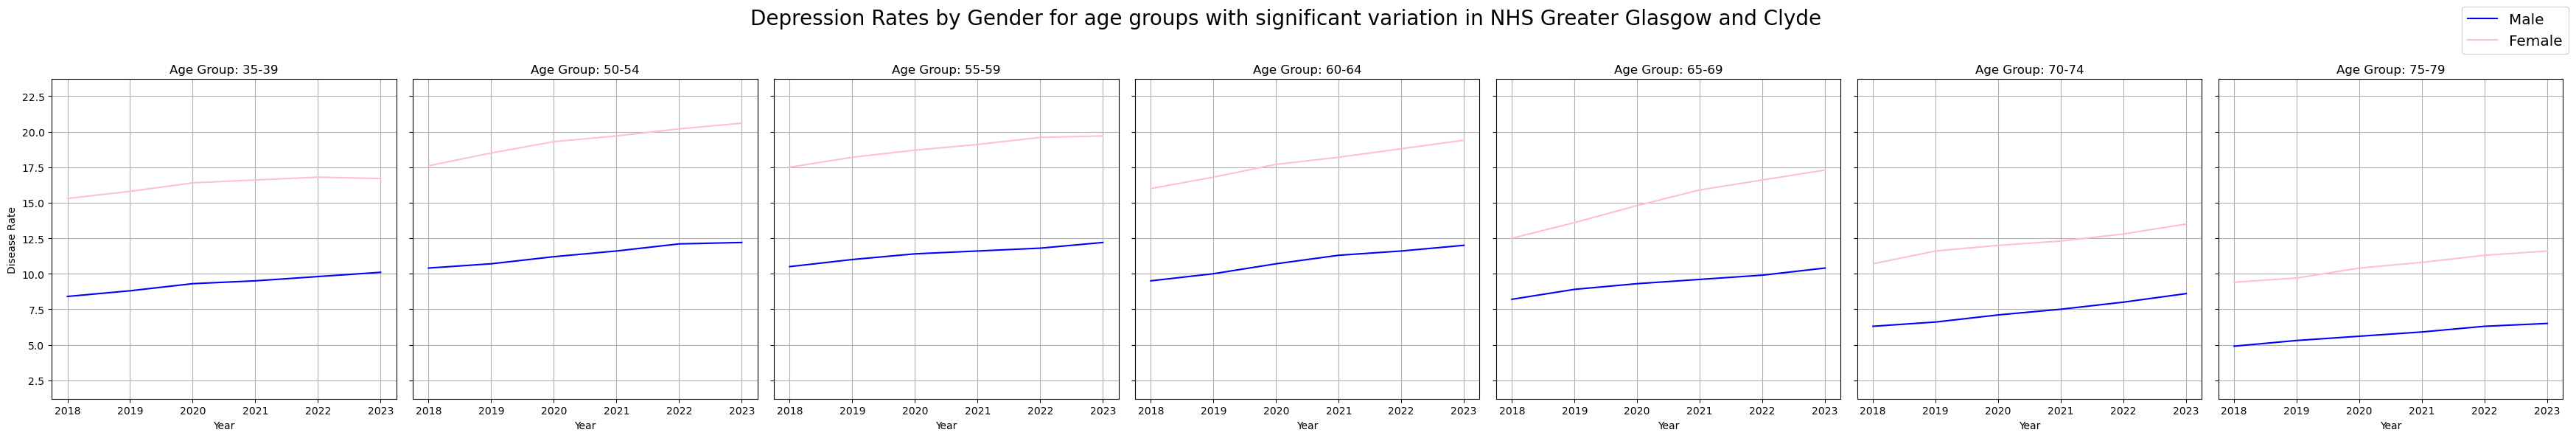

In [19]:
# Load the overall data
board_total = pd.read_excel('https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx', sheet_name="DP_Board_total")
board_m = pd.read_excel('diseaseprevalence_board_m.xlsx', sheet_name="DP_Board_M")
board_f = pd.read_excel('diseaseprevalence_board_f.xlsx', sheet_name="DP_Board_F")

# Define the area of interest and the disease for the analysis
selected_area = 'NHS Greater Glasgow and Clyde'
selected_disease = 'Rate_Depression'

# Filter the data for the selected area excluding the 'All' age group
area_data_total = board_total[(board_total['GPPractice/Area'] == selected_area) & (board_total['Age'] != 'All')]

# Initialize a list to hold age groups with significant rate variation
age_group_variation = []

# Initialize variables to hold the extreme values of disease rates
min_disease_rate, max_disease_rate = float('inf'), 0

# Loop through each age group to find those with significant variation in disease rates
for age_group in area_data_total['Age'].unique():
    data = area_data_total[area_data_total['Age'] == age_group]
    max_rate = data[selected_disease].max()
    min_rate = data[selected_disease].min()

    # If the variation is greater than or equal to 1.5, add to the list and update the extreme values
    if max_rate - min_rate >= 1.5:
        age_group_variation.append(age_group)
        max_disease_rate = max(max_disease_rate, max_rate, board_m[board_m['Age'] == age_group][selected_disease].max(), board_f[board_f['Age'] == age_group][selected_disease].max())
        min_disease_rate = min(min_disease_rate, min_rate, board_m[board_m['Age'] == age_group][selected_disease].min(), board_f[board_f['Age'] == age_group][selected_disease].min())

# Set up the subplots for each age group with significant variation
fig, axes = plt.subplots(nrows=1, ncols=len(age_group_variation), figsize=(5 * len(age_group_variation), 6))

# Plot the disease rate by gender for each significant age group
for i, age_group in enumerate(age_group_variation):
    ax = axes[i] if len(age_group_variation) > 1 else axes
    data_m = board_m[(board_m['GPPractice/Area'] == selected_area) & (board_m['Age'] == age_group)]
    data_f = board_f[(board_f['GPPractice/Area'] == selected_area) & (board_f['Age'] == age_group)]
    
    # Plot the male and female disease rates over the years
    ax.plot(data_m['Year'], data_m[selected_disease], color='blue')
    ax.plot(data_f['Year'], data_f[selected_disease], color='pink')

    # Set the title for each subplot based on the age group
    ax.set_title(f'Age Group: {age_group}')
    ax.set_xlabel('Year')
    ax.set_ylim([min_disease_rate, max_disease_rate])
    ax.grid(True)

    # Only show the y-axis label and ticks on the first subplot
    if i == 0:
        ax.set_ylabel('Disease Rate')
    else:
        ax.set_yticklabels([])

# Add an overall title to the figure
fig.suptitle('Depression Rates by Gender for age groups with significant variation in NHS Greater Glasgow and Clyde', fontsize=20, y=0.98)

# Add a legend to the figure to denote the line colors for male and female
fig.legend(['Male', 'Female'], loc='upper right', fontsize='x-large')

# Adjust the layout of the figure to prevent overlap and clipping
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the figure with the plots
plt.show()

Based on the description provided for the line charts depicting changes in depression rates by gender over time:

1. **Overall Increasing Trend:** Both males and females show an increasing trend in depression rates over time across the age groups analyzed.

2. **Higher and Faster Increase in Females:** Women exhibit higher rates of depression than men, with a more rapid increase over the observed years. This could be related to a range of biological, psychological, and social factors, including hormonal changes, stress from potentially balancing work and family responsibilities, and societal pressures that uniquely affect women.

3. **Significant Increase in Women Aged 60-69:** The particularly notable increase in depression rates among women aged 60-69 could be due to post-menopausal changes, increased life stressors such as caring for aging partners or dealing with bereavement, and potential isolation.

4. **Peak Rates in 50-64 Age Group:** The highest rates of depression being observed in the 50-64 age group could reflect the impact of midlife stressors, such as the "empty nest" syndrome, career pressures, or the onset of chronic health conditions that can trigger or exacerbate depression.

5. **Potential Causes for Gender Disparities:**
   - Biological Factors: Differences in brain chemistry and hormonal fluctuations may make women more susceptible to depression than men, especially during significant hormonal transition periods.
   - Sociocultural Factors: Women might experience more stress due to societal roles, expectations, and the potential for gender-based discrimination or violence.
   - Healthcare Utilization: Women are generally more likely to seek help for mental health issues, which might lead to higher reported rates of depression.

#### A set of `line charts` of Heart Failure Rates by Gender for age groups from 65-69 to 85plus in NHS Greater Glasgow and Clyde

For Heart Failure, since the target age groups selected are already limited, we will directly analyze all these age groups.

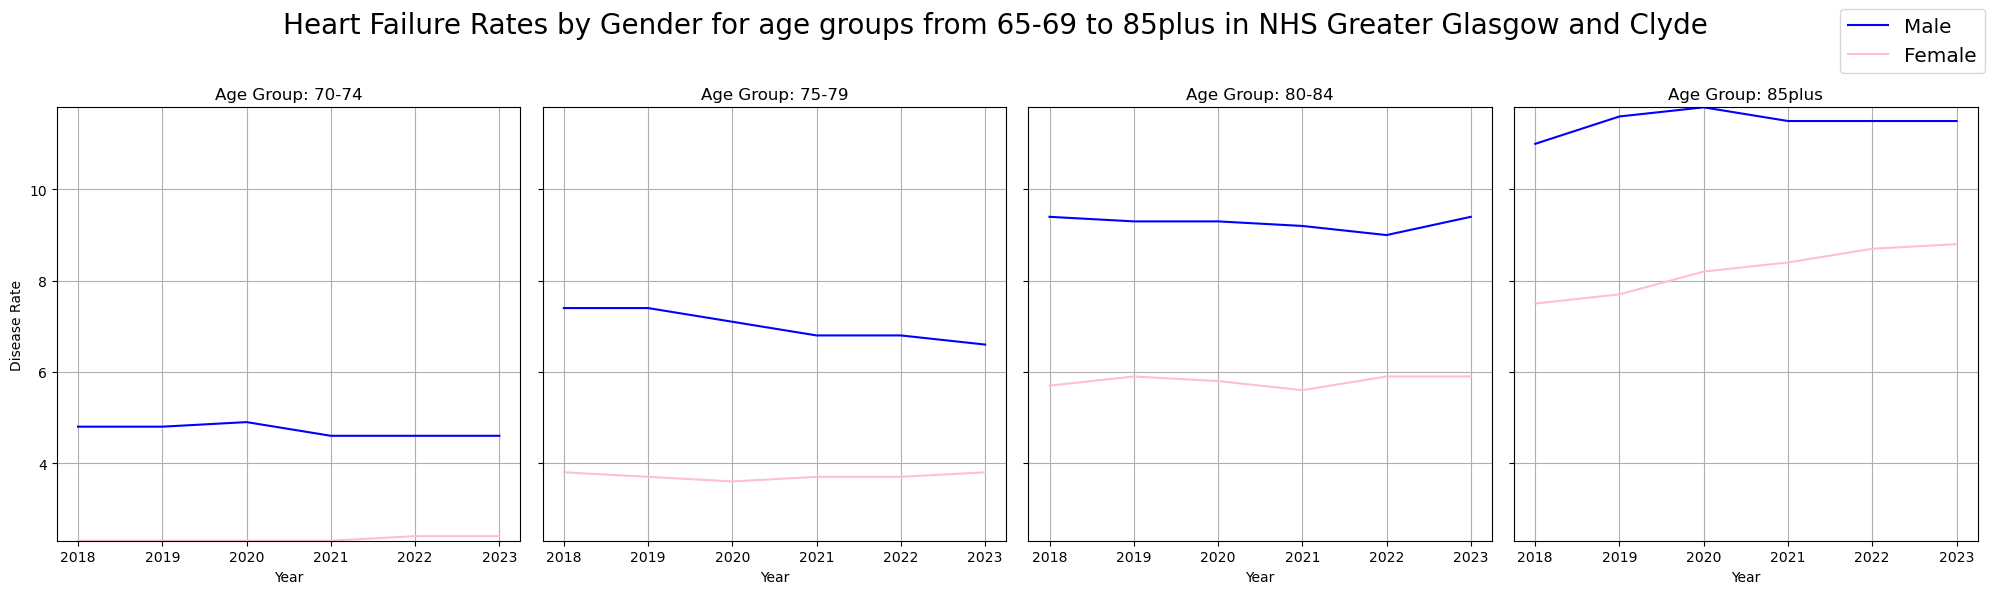

In [20]:
# Load the data
board_m = pd.read_excel('diseaseprevalence_board_m.xlsx', sheet_name="DP_Board_M")
board_f = pd.read_excel('diseaseprevalence_board_f.xlsx', sheet_name="DP_Board_F")

# Define the area of interest and the specific disease to analyze for trend variation
selected_area = 'NHS Greater Glasgow and Clyde'
selected_disease = 'Rate_Heart Failure'

# Initialize a list for the age groups to be excluded from the analysis
excluded_age_groups = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69']
# Create a list to keep track of age groups with significant variation in disease rates.
age_group_variation = []

# Initialize variables to store the minimum and maximum disease rates across age groups
min_disease_rate, max_disease_rate = float('inf'), 0

# Loop through all age groups, excluding the ones specified, to find significant disease rate variation
for age_group in board_m['Age'].unique():
    if age_group not in excluded_age_groups:
        # Filter data for the selected area and age group for both male and female datasets
        data_m = board_m[(board_m['GPPractice/Area'] == selected_area) & (board_m['Age'] == age_group)]
        data_f = board_f[(board_f['GPPractice/Area'] == selected_area) & (board_f['Age'] == age_group)]

        # Determine the maximum and minimum rates across the male and female data for the current age group
        max_rate = max(data_m[selected_disease].max(), data_f[selected_disease].max())
        min_rate = min(data_m[selected_disease].min(), data_f[selected_disease].min())

        # If the variation in rates exceeds or equals 1.5, add the age group to the list for further analysis
        if max_rate - min_rate >= 1.5:
            age_group_variation.append(age_group)
            # Update the overall maximum and minimum disease rates if the current ones are larger or smaller respectively
            max_disease_rate = max(max_disease_rate, max_rate)
            min_disease_rate = min(min_disease_rate, min_rate)

# Setup the subplots for each age group with significant rate variation
fig, axes = plt.subplots(nrows=1, ncols=len(age_group_variation), figsize=(5 * len(age_group_variation), 6))

# Iterate over each age group to plot the disease rate variation
for i, age_group in enumerate(age_group_variation):
    # Assign the axis for the current subplot; handle the case when there's only one subplot differently
    ax = axes[i] if len(age_group_variation) > 1 else axes
    
    # Plot the disease rate for males in the current age group
    data_m = board_m[(board_m['GPPractice/Area'] == selected_area) & (board_m['Age'] == age_group)]
    ax.plot(data_m['Year'], data_m[selected_disease], color='blue')

    # Plot the disease rate for females in the current age group
    data_f = board_f[(board_f['GPPractice/Area'] == selected_area) & (board_f['Age'] == age_group)]
    ax.plot(data_f['Year'], data_f[selected_disease], color='pink')

    # Set the title for the subplot using the age group
    ax.set_title(f'Age Group: {age_group}')
    # Label the x-axis as 'Year'
    ax.set_xlabel('Year')
    # Set the y-axis limits based on the minimum and maximum disease rates found
    ax.set_ylim([min_disease_rate, max_disease_rate])
    # Enable grid for better readability of the plots
    ax.grid(True)

    # Only display y-axis labels and ticks on the first subplot for a cleaner look
    if i == 0:
        ax.set_ylabel('Disease Rate')
    else:
        ax.set_yticklabels([])

# Add an overall title to the figure
fig.suptitle('Heart Failure Rates by Gender for age groups from 65-69 to 85plus in NHS Greater Glasgow and Clyde', fontsize=20, y=0.98)

# Add a legend to the figure to denote the line colors for male and female
fig.legend(['Male', 'Female'], loc='upper right', fontsize='x-large')

# Adjust the layout of the figure to prevent overlap and clipping
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Based on the description of the chart for heart failure rates by age and gender over time:

1. **Age-Related Increase:** The overall increase in heart failure rates with age is consistent with the general medical understanding that the risk of heart failure increases as people get older. This is due to a combination of age-related changes in the heart and vascular system, as well as the accumulation of other risk factors such as hypertension, coronary artery disease, and diabetes over a person's lifetime.

2. **Gender Differences:** The consistently higher rates of heart failure among men compared to women across most age groups could be attributed to several factors, including differences in heart disease risk factors, the protective effect of estrogen in pre-menopausal women, and possible differences in health-seeking behavior between genders.

3. **Significant Increase in Older Women (85+):** The marked increase in heart failure rates among women over 85 could be a result of the longer life expectancy of women, leading to a higher prevalence of age-related diseases, including heart failure. It might also reflect the onset of heart failure as other chronic conditions worsen or the delayed manifestation of heart disease symptoms in women.

4. **Decrease in Men Aged 75-79:** The observed decrease in heart failure rates for men aged 75-79 over time is intriguing. It might indicate the effectiveness of heart disease management strategies or healthcare interventions targeting this age group. Alternatively, it could be due to a survivorship bias where healthier individuals remain, or it could be a statistical anomaly that would need further investigation to understand fully. Heart failure rates remained relatively stable in men and women in other age groups.

The significant increase of heart failure rate in older women led to an overall increase over time in the 85 plus age group.

---
## **Investigate the seasonal change of medications of heart failure and depression in 2022**

Expanding on the approach to analyze seasonal changes in heart failure and depression, as well as their respective medications in 2022, we start by focusing on the complete data available from January through December. Our objective is to understand how the prevalence of these conditions and the use of medications fluctuate with the changing seasons. First, we needed to **find medications for heart failure and depression**. Based on the tables below, for heart failure, the BNF product codes begin with **0205**, and for depression, they start with **0403**. With these codes, we can accurately filter out the relevant medications from the dataset we are researching. Therefore, we need to find the BNF item codes that start with 0205 and 0403 and merge them into a new dataset called "New Prescriptions", which will then be divided into four sheets representing each of the four seasons.

In [21]:
BNF = pd.read_excel('BNF-code-reference.xlsx')
depression = BNF[BNF['BNF Section'] == 'Antidepressant drugs']
heart_failure = BNF[BNF['BNF Section'] == 'Hypertension and heart failure']
depression.head()

,BNF Chapter,BNF Chapter Code,BNF Section,BNF Section Code,BNF Paragraph,BNF Paragraph Code,BNF Subparagraph,BNF Subparagraph Code,BNF Chemical Substance,BNF Chemical Substance Code,BNF Product,BNF Product Code,BNF Presentation,BNF Presentation Code
6554,Central Nervous System,4,Antidepressant drugs,403,Tricyclic and related antidepressant drugs,40301,Tricyclic and related antidepressant drugs,403010,Amitriptyline hydrochloride,0403010B0,Amitriptyline hydrochloride,0403010B0AA,Amitriptyline 75mg/5ml oral solution,0403010B0AAA1A1
6555,Central Nervous System,4,Antidepressant drugs,403,Tricyclic and related antidepressant drugs,40301,Tricyclic and related antidepressant drugs,403010,Amitriptyline hydrochloride,0403010B0,Amitriptyline hydrochloride,0403010B0AA,Amitriptyline 100mg/5ml oral solution,0403010B0AAA2A2
6556,Central Nervous System,4,Antidepressant drugs,403,Tricyclic and related antidepressant drugs,40301,Tricyclic and related antidepressant drugs,403010,Amitriptyline hydrochloride,0403010B0,Amitriptyline hydrochloride,0403010B0AA,Amitriptyline 25mg/5ml oral suspension,0403010B0AAA5A5
6557,Central Nervous System,4,Antidepressant drugs,403,Tricyclic and related antidepressant drugs,40301,Tricyclic and related antidepressant drugs,403010,Amitriptyline hydrochloride,0403010B0,Amitriptyline hydrochloride,0403010B0AA,Amitriptyline 10mg/5ml oral liquid,0403010B0AAA6A6
6558,Central Nervous System,4,Antidepressant drugs,403,Tricyclic and related antidepressant drugs,40301,Tricyclic and related antidepressant drugs,403010,Amitriptyline hydrochloride,0403010B0,Amitriptyline hydrochloride,0403010B0AA,Amitriptyline 80mg/5ml oral solution,0403010B0AAA7A7


In [22]:
heart_failure.head()

,BNF Chapter,BNF Chapter Code,BNF Section,BNF Section Code,BNF Paragraph,BNF Paragraph Code,BNF Subparagraph,BNF Subparagraph Code,BNF Chemical Substance,BNF Chemical Substance Code,BNF Product,BNF Product Code,BNF Presentation,BNF Presentation Code
2251,Cardiovascular System,2,Hypertension and heart failure,205,Vasodilator antihypertensive drugs,20501,Vasodilator antihypertensive drugs,205010,Macitentan,0205010AA,Macitentan,0205010AAAA,Macitentan 10mg tablets,0205010AAAAAAAA
2252,Cardiovascular System,2,Hypertension and heart failure,205,Vasodilator antihypertensive drugs,20501,Vasodilator antihypertensive drugs,205010,Macitentan,0205010AA,Opsumit,0205010AABB,Opsumit 10mg tablets,0205010AABBAAAA
2253,Cardiovascular System,2,Hypertension and heart failure,205,Vasodilator antihypertensive drugs,20501,Vasodilator antihypertensive drugs,205010,Riociguat,0205010AB,Riociguat,0205010ABAA,Riociguat 500microgram tablets,0205010ABAAAAAA
2254,Cardiovascular System,2,Hypertension and heart failure,205,Vasodilator antihypertensive drugs,20501,Vasodilator antihypertensive drugs,205010,Riociguat,0205010AB,Riociguat,0205010ABAA,Riociguat 1mg tablets,0205010ABAAABAB
2255,Cardiovascular System,2,Hypertension and heart failure,205,Vasodilator antihypertensive drugs,20501,Vasodilator antihypertensive drugs,205010,Riociguat,0205010AB,Riociguat,0205010ABAA,Riociguat 1.5mg tablets,0205010ABAAACAC


#### A `bubble chart` for the medicine usage for heart failure and depression in 2022

In [23]:
# Import the data based on four seasons
S1 = pd.read_excel('New Prescriptions .xlsx',sheet_name = 'Season1')
S2 = pd.read_excel('New Prescriptions .xlsx',sheet_name = 'Season2')
S3 = pd.read_excel('New Prescriptions .xlsx',sheet_name = 'Season3')
S4 = pd.read_excel('New Prescriptions .xlsx',sheet_name = 'Season4')

# Set up diseases data
depression1 = S1[S1['BNFItemCode'].astype(str).str.startswith('0403')]['NumberOfPaidItems'].sum()
depression2 = S2[S2['BNFItemCode'].astype(str).str.startswith('0403')]['NumberOfPaidItems'].sum()
depression3 = S3[S3['BNFItemCode'].astype(str).str.startswith('0403')]['NumberOfPaidItems'].sum()
depression4 = S4[S4['BNFItemCode'].astype(str).str.startswith('0403')]['NumberOfPaidItems'].sum()
Heart_failure1 = S1[S1['BNFItemCode'].astype(str).str.startswith('0205')]['NumberOfPaidItems'].sum()
Heart_failure2 = S2[S2['BNFItemCode'].astype(str).str.startswith('0205')]['NumberOfPaidItems'].sum()
Heart_failure3 = S3[S3['BNFItemCode'].astype(str).str.startswith('0205')]['NumberOfPaidItems'].sum()
Heart_failure4 = S4[S4['BNFItemCode'].astype(str).str.startswith('0205')]['NumberOfPaidItems'].sum()

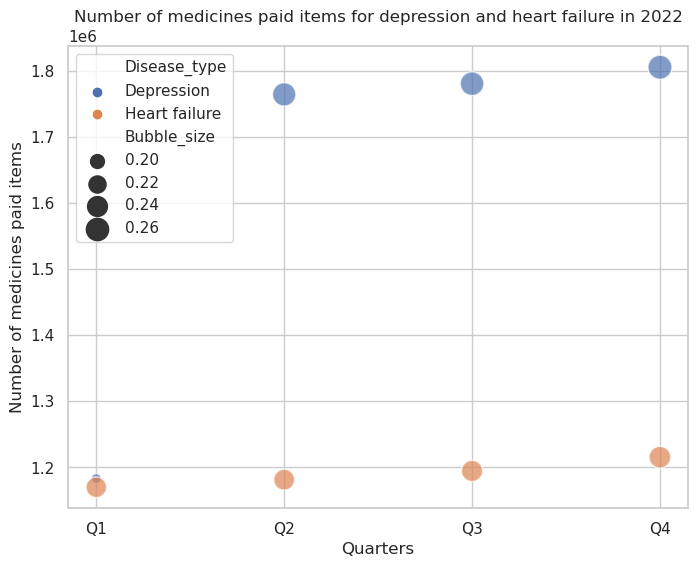

In [24]:
# Set the intial variables.
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
depression = [depression1, depression2, depression3, depression4]  
heart_failure = [Heart_failure1, Heart_failure2, Heart_failure3, Heart_failure4]

# Sum the number of paid items based on two diseases
total_d= sum(depression)
total_h = sum(heart_failure)

# Initialize the bubble size as the proportion of quarters paid items in 2022.
proportion_d = [x / total_d for x in depression]
proportion_h = [x / total_h for x in heart_failure]

# Construct the data frame
data = {'Quarter': quarters * 2,
        'Disease_type': ['Depression'] * len(quarters) + ['Heart failure'] * len(quarters),
        'Paid_items': depression + heart_failure,
        'Bubble_size': proportion_d + proportion_h} 

items = pd.DataFrame(data)

# Set the plots using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Quarter', y='Paid_items', hue='Disease_type', size='Bubble_size',
                sizes=(50, 300), data=items, alpha=0.7)

#  Add titles
plt.xlabel('Quarters')
plt.ylabel('Number of medicines paid items')
plt.title('Number of medicines paid items for depression and heart failure in 2022')

# Add plots labels
plt.legend()

# Show the plots
plt.show()

The bubble size represents the proportion of the number of medicines used in this quarter to the entire year, the orange bubble represents heart failure, the blue bubble represents depression, and the y-axis shows the number of medicines usage. The medicine usage shows the **increasing trend** in the whole year.

It shows that in the first quarter, the depression medicine usage is significantly small, which might indicate that **depression incidence is low in the first quarter**. 

#### Two `wordclouds` for the medicine usage for heart failure and depression for the fourth quarter in 2022

Based on the graph above, we can see that the highest number of medicines were paid in the fourth quarter. Here, we use wordcloud to see the frequency of medicines. A wordcloud is a visual representation of textual data where the size of each word indicates its frequency or importance in a given context. In this word cloud, various medication names are shown, some of which are larger than others, indicating that they are mentioned more frequently. The medications represented in the wordcloud belong to various classes, including antidepressants, antihypertensives, and others that are used for heart failure. In the word cloud, larger words represent those medications that are more frequently prescribed or mentioned in the dataset. This visualization technique makes it easier to identify which medications are most commonly used in the treatment of heart failure and depression during this period.

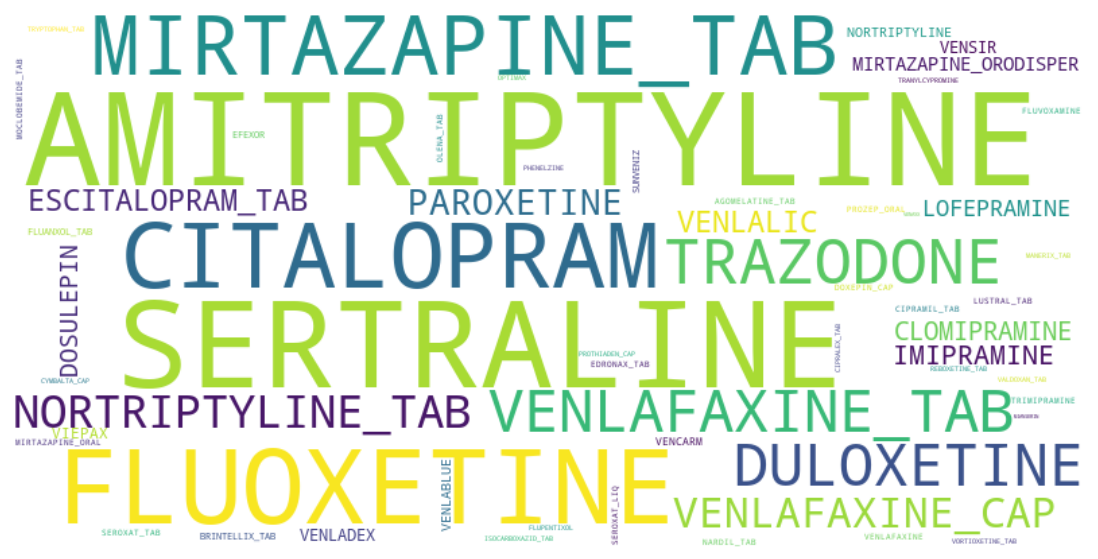

In [25]:
# Look only on the prescription of depression
depression_s4 = S4[S4['BNFItemCode'].astype(str).str.startswith('0403')]
depression_s4 = depression_s4.copy()
# Convert the 'PaidQuantity' column to integers
# This step is necessary because frequencies for a word cloud need to be integer values
depression_s4['PaidQuantity'] = depression_s4['PaidQuantity'].astype(int)

# Create a new column 'BNFItem' which contains the first word from each description in 'BNFItemDescription'
depression_s4['BNFItem'] = depression_s4['BNFItemDescription'].apply(lambda x: x.split()[0])

# Create a dictionary by grouping 'BNFItem' and summing up the 'PaidQuantity' for each group
frequency = depression_s4.groupby('BNFItem')['PaidQuantity'].sum().to_dict()

# Create a WordCloud object, setting the image width, height, and background color
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(frequency)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

```python
# Lines 15-18: word cloud
# URL: https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/
# Accessed on 21 Nov 2023.
```

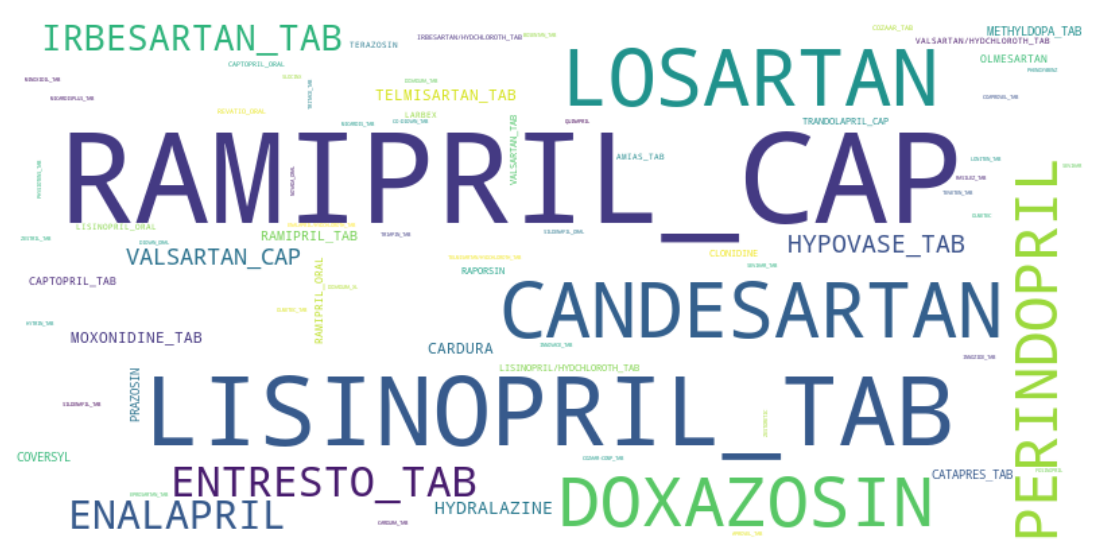

In [26]:
# Look only on the prescription of heart failure
heartfailure_s4 = S4[S4['BNFItemCode'].astype(str).str.startswith('0205')]

heartfailure_s4 = heartfailure_s4.copy()
# Convert the 'PaidQuantity' column to integers
# This step is necessary because frequencies for a word cloud need to be integer values
heartfailure_s4['PaidQuantity'] = heartfailure_s4['PaidQuantity'].astype(int)

# Create a new column 'BNFItem' which contains the first word from each description in 'BNFItemDescription'
heartfailure_s4['BNFItem'] = heartfailure_s4['BNFItemDescription'].apply(lambda x: x.split()[0])

# Create a dictionary by grouping 'BNFItem' and summing up the 'PaidQuantity' for each group
frequency2 = heartfailure_s4.groupby('BNFItem')['PaidQuantity'].sum().to_dict()

# Create a WordCloud object, setting the image width, height, and background color
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud using the frequency dictionary
wordcloud.generate_from_frequencies(frequency2)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The medications depicted in the word cloud encompass a range of drug classes. Antidepressants, are a key class in this context, reflecting their use in healing depression. Hypertension and heart failure is also an important class for solving heart failure problems. In the wordclouds above, **various medication names are shown**, some of which are larger than others, indicating that they are mentioned more frequently. The medications represented in the wordcloud belong to various classes, including antidepressants, antihypertensives, and others that are used for heart failure.

#### A `heatmap` to compare depression and heart failure related prescriptions geographically

Finally, we want to know if the number of prescriptions patients paid for these two diseases has some particular features or patterns in geographical locations. Are there any differences between these two kinds of prescriptions? To answer them, it is better to obtain a map with corresponding numbers.

The first thing is to clean, group, and organize data into a tidy form that can join with the data having longitude and latitude information in the first section. Like the previous urban and rural section, a heatmap is used here with different densities for numbers in each GP. 

In [27]:
# Concatenate four DataFrames for different seasons into one
one_year_pres = pd.concat([S1, S2, S3, S4], ignore_index=True)

# Filter prescriptions related to depression (BNFItemCode starts with '0403')
one_year_pres_dep = one_year_pres[one_year_pres['BNFItemCode'].astype(str).str.startswith('0403')]
# Filter prescriptions related to heart diseases (BNFItemCode starts with '0205')
one_year_pres_heart = one_year_pres[one_year_pres['BNFItemCode'].astype(str).str.startswith('0205')]

# Group by GPPractice and sum PaidQuantity for depression-related and heartfailure-related prescriptions
max_dep_pre = one_year_pres_dep.groupby('GPPractice')['PaidQuantity'].sum()
max_heart_pre = one_year_pres_heart.groupby('GPPractice')['PaidQuantity'].sum()

# Merge depression data with longitude and latitude data, dropping rows with missing values for two diseases
data_for_dep_map = pd.merge(max_dep_pre, gp_long_lat, left_on='GPPractice', right_on='Practice Code', how='left').dropna()
data_for_heart_map = pd.merge(max_heart_pre, gp_long_lat, left_on='GPPractice', right_on='Practice Code', how='left').dropna()

# Initialize a folium map centered at a specific location
map = folium.Map(location=[56.4907, -4.2026], zoom_start=6)

# Define a color gradient for the heatmap
gradient = {
    0.2: 'blue',   # low density
    0.4: 'cyan',   # medium-low density
    0.6: 'lime',   # medium density
    0.8: 'yellow', # medium-high density
    1: 'red'       # high density
}

# Prepare data for depression heatmap
dep_map = [[row['Latitude'], row['Longitude'], row['PaidQuantity']] for index, row in data_for_dep_map.iterrows()]
# Add depression heatmap to the map
heat_dep_map = HeatMap(dep_map, radius=15, max_zoom=10, gradient=gradient, name='Depression').add_to(map)

# Prepare data for heart disease heatmap
heart_map = [[row['Latitude'], row['Longitude'], row['PaidQuantity']] for index, row in data_for_heart_map.iterrows()]
# Add heart disease heatmap to the map
heat_heart_map = HeatMap(heart_map, radius=15, max_zoom=10, gradient=gradient, name='Heart Failure').add_to(map)

# Add layer control to the map
folium.LayerControl().add_to(map)
# Save the map to an HTML file
map.save('Depression and Heart Failure Prescription Distribution Density.html')

# Display the map
map

```python
# Lines 15-44: Folium
# URL: https://python-visualization.github.io/folium/latest/user_guide/plugins/heatmap.html
# Accessed on 25 Nov 2023.
```

In general, pay attention to the above heatmap, there is almost **no difference geographically** for heart failure and depression prescriptions, especially for areas excluding Glasgow and Edinburgh. The area where drugs for both 2 diseases are purchased **covers almost the whole of Scotland**. There are only a few small changes in the center of Glasgow. This suggests that these two diseases are relatively common in life so their drugs cover rate are high enough. Another important point is **people tend to buy these related drugs from big cities like Glasgow, Edinburgh, and Aberdeen**. 

On the one hand, the reason may be that the population in these areas is large, so the number of paid drugs is reasonably large, and it may also be because people living in these large areas are prone to these two types of diseases, so the demand is large. On the other hand, these big cities are likely better at treating depression and heart failure, therefore patients would like to buy and treat in these cities.

---
## **Conclusion and discussion**

Based on the visual analysis of the provided data, the following conclusions have been drawn:

**Differences in Urban and Rural Areas:**
- Geographically, rural GP registrations are mainly concentrated along coastlines, railway lines, and urban outskirts. A representative selection of six boards has been identified for further study in this section.
- It's observed that the number of GPs in urban areas is significantly higher than in rural areas, with an overall upward trend over time.
- There are slight differences in the types of diseases prevalent among the elderly in urban and rural areas, with hypertension being the most common ailment across the board.
- Patients in urban areas prefer living in nursing homes, and their numbers are increasing over time.
- The economic status varies within these areas, contradicting the stereotype that all rural residents are impoverished and all urban residents are wealthy.

**Analysis of depression and heart failure:**
- Depression is more prevalent in the middle-aged group and has been increasing annually.
- Heart failure has a low incidence in individuals under 55 years of age, with a concentration of cases in the elderly population, and its prevalence increases with age. However, as time progresses, the rate across all age groups remains stable throughout Scotland, while in the Glasgow area, there is a trend of increasing rates over time among those aged 85 and above.
- Females are more prone to depression, while males are more susceptible to heart failure.
- Glasgow region shows a higher rate of illness and a larger number of patients than the Scottish average.

**Related prescription of depression and heart failure:**
- In 2022, the use of medication for both diseases increased, with a noticeable decrease in depression cases in the first quarter.
- The wordcloud plot highlights the most commonly used medications.
- While there is not much difference in the medications for these two diseases, their prevalence and consumption are high in Scotland, particularly concentrated in larger cities.

In a nutshell, the analysis indicates a clear disparity between urban and rural healthcare, both in terms of available resources and disease prevalence. Besides, the development of heart failure and depression have been analyzed with respect to age groups, gender, and particular boards. The medications related to these two types of diseases also have been studied to find if there is a seasonal pattern and other features. 

In the future, there are several suggesstions to address the highlighted health trends and disparities. Firstly, enhancing mental health support, particularly for middle-aged individuals and in urban areas, is very crucial. This could involve implementing comprehensive mental health programs, increasing accessibility to counseling and psychiatric services, and raising awareness about mental health issues. Secondly, for the elderly population, especially those over 85, there's a need for specialized cardiac care programs. These should focus on both treatment and preventative measures to manage the rising trend of heart failure. Regional healthcare disparities, notably in Glasgow, call for region-specific healthcare strategies and increased funding to manage the higher disease burden effectively. Lastly, ensuring the availability and accessibility of essential medications, especially in urban areas with higher consumption rates, is vital. This entails careful planning in pharmaceutical supply chain management and healthcare resource allocation. By addressing these areas, future healthcare policies can be more tailored and effective, leading to an overall improvement in health outcomes across different demographics and regions.


---

## **References**



demographics: 

https://publichealthscotland.scot/media/22255/demographics_2023_q1.xlsx

urban and rural: 

https://publichealthscotland.scot/media/17340/table8_practice_populations_by_urban_rural_classification_2012_2022_revision_110123.xlsx

gp contact: 

https://publichealthscotland.scot/media/23098/2023-10-gp-contact-details.xlsx

small user: 

https://www.nrscotland.gov.uk/statistics-and-data/geography/our-products/scottish-postcode-directory/2023-2

gp numbers: 

https://publichealthscotland.scot/media/16747/table2_number_of_gps_nhsboard_designation_sex_2012_2022.xlsx

disease and board:

https://publichealthscotland.scot/media/21136/diseaseprevalence_board_total.xlsx
https://publichealthscotland.scot/media/21134/diseaseprevalence_board_f.xlsx
https://publichealthscotland.scot/media/21135/diseaseprevalence_board_m.xlsx
https://publichealthscotland.scot/media/21148/diseaseprevalence_scotland_total.xlsx

New prescription: 

https://github.com/pypr23/project-2-group-30/blob/main/New%20Prescriptions%20.xlsx



